# Experiments with DIFFI

With this notebook we want to test how many and which of the important features have been exploited by each isolation tree in a given isolation forest.

## Imports & Initializations

In [1]:
import os
import numpy as np
import pickle as pkl 
import matplotlib.pyplot as plt 
%matplotlib inline
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# import shap
# import diffi.interpretability_module as interp
from diffi.utils import *
import wandb
import pandas as pd
import odds_datasets
import seaborn as sns

/Users/sebastianosanson/Documents/Master Thesis/Master-Thesis/mt_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sanson-sebastiano-00 (sanson-sebastiano-00-universita-di-padova) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
np.random.seed(0)

## Dataset

### Synthetic Dataset

In [4]:
n_features = 20   # Total number of features
n_meaningful = 2  # Number of meaningful features

# Parameters
n_regular = 900  # Number of regular data points
n_anomalous = 100  # Number of anomalous data points

In [5]:
def generate_syn_dataset():
    # Generate regular data
    rho_regular = np.random.uniform(0, 3, n_regular)
    theta_regular = np.random.uniform(0, 2 * np.pi, n_regular)
    meaningful_regular = np.column_stack((rho_regular * np.cos(theta_regular), 
                                        rho_regular * np.sin(theta_regular)))

    # Generate anomalous data
    rho_anomalous = np.random.uniform(4, 30, n_anomalous)
    theta_anomalous = np.random.uniform(0, 2 * np.pi, n_anomalous)
    meaningful_anomalous = np.column_stack((rho_anomalous * np.cos(theta_anomalous), 
                                            rho_anomalous * np.sin(theta_anomalous)))

    # Combine meaningful features
    meaningful_features = np.vstack((meaningful_regular, meaningful_anomalous))

    # Generate noise features
    noise_features = np.random.normal(0, 1, (n_regular + n_anomalous, n_features - n_meaningful))

    # Combine meaningful and noise features
    data = np.hstack((meaningful_features, noise_features))

    # Create labels (0 for regular, 1 for anomalous)
    labels = np.array([0] * n_regular + [1] * n_anomalous)

    contamination = n_anomalous / (n_regular + n_anomalous)

    return data, labels, contamination

# columns = [f"Feature_{i+1}" for i in range(n_features)]
# train_df = pd.DataFrame(data, columns=columns)
# train_df['Label'] = labels

# print(train_df.head())

In [6]:
# plt.figure(figsize=(10, 6))
# plt.scatter(train_df[train_df['Label'] == 0]['Feature_1'], train_df[train_df['Label'] == 0]['Feature_2'], 
#             label='Regular', alpha=0.6, c='blue')
# plt.scatter(train_df[train_df['Label'] == 1]['Feature_1'], train_df[train_df['Label'] == 1]['Feature_2'], 
#             label='Anomalous', alpha=0.6, c='red')

# plt.xlabel('Feature_1')
# plt.ylabel('Feature_2')
# plt.title('Scatter Plot of the Dataset')
# plt.legend()
# plt.show()

# train_set = np.column_stack((data, labels))

### Outlier Detection Datasets - ODDS

In [7]:
# def load_dataset(seed):
#       for i, dataset in enumerate(odds_datasets.datasets_names):
#             X, y = odds_datasets.load(dataset)
#             contamination = y.mean()
#             X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, stratify=y)

## Parameters and Functions definitions

Parameters for the model

In [8]:
num_trees = 100
max_samples = 256
n_forests = 1
usage_threshold = 0.2

In [9]:
def log_model_config(contamination):
    """
    Log the model configuration parameters to wandb.
    """
    config_data = [
        ["num_trees", num_trees],
        ["max_samples", max_samples],
        ["n_forests", n_forests],
        ["contamination", contamination],
        ["usage_threshold", usage_threshold],
    ]

    config_table = wandb.Table(data=config_data, columns=["Parameter", "Value"])

    wandb.log({"Configuration Table": config_table})

Plotting the feature importance values for each feature

In [10]:
def log_feature_importance(feature_rank, fi_means, fi_std, og_model: bool):
    """
    Plot and log the feature importance to wandb.
    """
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(feature_rank)), fi_means[feature_rank], yerr=fi_std[feature_rank])
    plt.xticks(range(len(feature_rank)), feature_rank)
    plt.xlabel('Feature index')
    plt.ylabel('Feature importance')
    if og_model:
        plt.title('Feature importance on original model')
        wandb.log({"original_model_feature_importance_image": wandb.Image(plt)})
    else:
        plt.title('Feature importance on new model')
        wandb.log({"new_model_feature_importance_image": wandb.Image(plt)})

    # plt.show()

Plotting the heatmap of feature importance for every trees 

In [11]:
def log_feature_importance_heatmap(fi_diffi, for_inliers: bool):
    """
    Log the feature importance heatmap to wandb.
    """
    for i, forest in enumerate(fi_diffi):
        plt.figure(figsize=(12, 8))
        plt.plot(1, len(fi_diffi), i + 1)
        sns.heatmap(forest, cmap='viridis', cbar=True, vmin=0, vmax=0.16)
        plt.xlabel('Feature Index')
        plt.ylabel('Tree Index')
        # plt.tight_layout()
        if for_inliers:
            plt.title(f'Feature Importance Heatmaps for Inliers - Forest {i + 1}', fontsize=16)
            wandb.log({"feature_importance_heatmap_inliers": wandb.Image(plt)})
        else:
            plt.title(f'Feature Importance Heatmaps for Outliers - Forest {i + 1}', fontsize=16)
            wandb.log({"feature_importance_heatmap_outliers": wandb.Image(plt)})
        # plt.show()

We compute the global usage of each feature over the isolation forests of the model

In [12]:
def feature_usage(features_per_forest, num_features):
    """
    Computing and plotting the feature usage in each tree and forest.
    """
    usage_per_forest = np.zeros((n_forests, num_features), 
                                dtype=object)    # shape: (number of forests, number of features)
    usage_per_tree = np.zeros((n_forests, num_trees, num_features), 
                            dtype=object)  # shape: (number of forests, number of trees, number of features)


    for i in range(num_features):                                                      # for each feature                                     
        for j, forest in enumerate(features_per_forest):                                # for each forest
            for k, tree in enumerate(forest):                                           # for each tree
                # count the number of times feature i is used in tree k in forest j
                usage_per_tree[j, k, i] = np.sum([1 for feature in tree if feature == i])   
            # count the number of times feature i is used in forest j
            usage_per_forest[j, i] = np.sum(usage_per_tree[j, :, i])                          

    # print(np.array(usage_per_forest, dtype=object).shape)
    # print(np.array(usage_per_tree, dtype=object).shape)

    plt.figure(figsize=(12, 6))
    for i in range(usage_per_forest.shape[0]):
        plt.bar(range(usage_per_forest.shape[1]), usage_per_forest[i], alpha=0.5, label=f'Forest {i+1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Usage Count')
    plt.title('Feature Usage Across Forests')
    plt.legend()
    plt.tight_layout()

    wandb.log({"feature_usage_image": wandb.Image(plt)})

    # plt.show()

    return usage_per_forest, usage_per_tree

Counting how many times the `most_important_features`are used in each Isolation Tree

In [13]:
def most_important_feature_usage(most_important_features, usage_per_tree, features_per_forest):
    """
    Compute the usage of the most important features in each tree.
    """
    most_important_features_usage = np.zeros((len(most_important_features), 
                                                n_forests, num_trees))    # shape: (number of meaningful features, number of forests, number of trees)
    # print(most_important_features_usage.shape)

    for i in range(len(most_important_features)):
        for j, forest in enumerate(features_per_forest):
            for k, tree in enumerate(forest):
                most_important_features_usage[i, j, k] = usage_per_tree[j, k, i] / len(tree)  

    # print('Two most important features usage:', most_important_features_usage)

    most_important_features_usage_percentage = np.zeros((len(most_important_features), 
                                                            n_forests, num_trees))    # shape: (number of meaningful features, number of forests, number of trees)
    # Normalize the usage by the maximum usage in each forest
    for i, feature in enumerate(most_important_features_usage):
        for j, forest in enumerate(feature):
            max = np.max(forest)
            for k, tree in enumerate(forest):
                most_important_features_usage_percentage[i, j, k] = most_important_features_usage[i, j, k] / max

    # print('Two most important features usage percentage:', most_important_features_usage_percentage)

    # Plotting the percentage of usage of `most_important_features` across isolation trees
    plt.figure(figsize=(12, 6))
    for i, feature in enumerate(most_important_features):
        plt.subplot(1, 2, i+1)
        for j in range(n_forests):
            plt.bar(range(num_trees), most_important_features_usage_percentage[i, j, :], alpha=0.5, label=f'Forest {j+1}')
        plt.xlabel('Tree Index')
        plt.ylabel('Usage Percentage')
        plt.title(f'Usage Percentage of Feature {feature}')
        plt.legend()
    plt.tight_layout()

    # run.log({"most_important_features_usage_image": wandb.Image(plt)})

    # plt.show()

    return most_important_features_usage_percentage

Calculating the average of the `most_important_features_usage_percentage` for each `most_important_features`

In [14]:
def average_usage(most_important_features_usage_percentage, most_important_features):
    """
    Compute the average usage of the most important features across forests.
    """
    
    average_usage_percentage = np.zeros((len(most_important_features), n_forests))    # shape: (number of meaningful features, number of forests)
    for i in range(len(most_important_features)):
        for j in range(n_forests):
            average_usage_percentage[i, j] = np.mean(most_important_features_usage_percentage[i, j, :])
    print('Average usage percentage:', average_usage_percentage)

    # TODO: riflettere se effettuare il log anche di queste medie

    # compute the average usage percentage for each forest across all features
    average_usage_percentage_forest = np.zeros(n_forests)    # shape: (number of forests, number of trees)
    for i in range(n_forests):
        average_usage_percentage_forest[i] = np.mean(average_usage_percentage[:, i])
    print('Average usage percentage for each forest:', average_usage_percentage_forest)

    plt.figure(figsize=(12, 6))
    for i, feature in enumerate(most_important_features):
        plt.subplot(1, 2, i+1)
        for j in range(n_forests):
            plt.bar(range(num_trees), most_important_features_usage_percentage[i, j, :], alpha=0.5, label=f'Forest {j+1}')
            plt.axhline(y=average_usage_percentage[i, j], color=f'C{j}', linestyle='--', label=f'Average Usage Percentage for Forest {j+1}')
        plt.xlabel('Tree Index')
        plt.ylabel('Usage Percentage')
        plt.title(f'Usage Percentage of Feature {feature}')
        plt.legend()
    plt.tight_layout()
    # plt.show()

Now we are going to select the indexes of the trees to be removed from the original iForests

In [15]:
def removing_trees(most_important_features_usage_percentage, most_important_features, iforests):
    """
    Remove the trees with usage percentage less than the threshold.
    """
    
    # save indexes of the trees to be removed
    tree_idx = np.zeros((len(most_important_features), n_forests), dtype=object)  # shape: (number of meaningful features, number of forests)
    print(tree_idx.shape)

    for i, feature in enumerate(most_important_features_usage_percentage):
        for j, forest in enumerate(feature):
            tree_idx[i, j] = np.where(forest < wandb.config.usage_threshold)[0]  # get the indexes of the trees where the usage percentage is less than usage_threshold
            print(f"Feature {most_important_features[i]} in Forest {j+1} has trees with usage percentage < {wandb.config.usage_threshold}: {tree_idx[i, j]}")

    # Concatenating and removing duplicates
    tree_to_be_removed = np.zeros(n_forests, dtype=object)
    print(tree_to_be_removed.shape)

    for i in range(n_forests):
        # concatenate the indexes of the trees to be removed for each feature
        concatenated = np.concatenate(([feature[i] for feature in tree_idx]), axis=0)
        # print('concatenated: {}'.format(concatenated))
        # remove duplicates
        concatenated = np.unique(concatenated)
        # print('unique: {}'.format(concatenated))
        tree_to_be_removed[i] = concatenated

    print(tree_to_be_removed)
    print('Number of trees to be removed: ', [len(tree_to_be_removed[i]) for i in range(len(tree_to_be_removed))])

    # remove the trees from the forests
    for i, forest in enumerate(iforests):
        # print(f'Forest {i}:')
        
        # Get the list of trees and their corresponding features
        trees = forest.estimators_
        features = forest.estimators_features_

        # print(' Number of trees before removal:', len(trees))
        # print(' Number of features in trees before removal:', len(features))
        
        # Remove the specified trees and their features
        trees_to_keep = [tree for idx, tree in enumerate(trees) if idx not in tree_to_be_removed[i]]
        features_to_keep = [feature for idx, feature in enumerate(features) if idx not in tree_to_be_removed[i]]
        
        # Update the forest with the filtered lists
        forest.estimators_ = trees_to_keep
        forest.estimators_features_ = features_to_keep

        # Update internal attributes to match the reduced number of trees
        forest._decision_path_lengths = [forest._decision_path_lengths[idx] for idx in range(len(trees)) if idx not in tree_to_be_removed[i]]
        forest._average_path_length_per_tree = [forest._average_path_length_per_tree[idx] for idx in range(len(trees)) if idx not in tree_to_be_removed[i]]
        
        # print(' Number of trees after removal:', len(forest.estimators_))
        # print(' Number of features after removal:', len(forest.estimators_features_))

    print('Number of trees after removal: ', [len(iforests[i].estimators_) for i in range(len(iforests))])
    print('Number of features in trees after removal: ', [len(iforests[i].estimators_features_) for i in range(len(iforests))])
    print('Number of decision path lengths after removal: ', [len(iforests[i]._decision_path_lengths) for i in range(len(iforests))])
    print('Number of average path lengths after removal: ', [len(iforests[i]._average_path_length_per_tree) for i in range(len(iforests))])

This function computes the difference of the feature importance, for each features, between the original and new model

In [16]:
def compute_difference(fi_means, new_fi_means, sorted_idx):
    """
    Compute the difference in feature importance between the original and new model.
    """
    
    diff = []
    for idx in sorted_idx:
        diff.append(new_fi_means[idx] - fi_means[idx])
        
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(diff)), diff)
    plt.xticks(range(len(diff)), sorted_idx)
    plt.xlabel('Feature index')
    plt.ylabel('Difference in Feature Importance')
    plt.title('Difference in Feature Importance')
    # 
    wandb.log({"difference_feature_importance_image": wandb.Image(plt)})

    # plt.show()

## Launch experiments

Seed: 0
Training set size:  (900, 20)
Trainin label size:  (900,)
Test set size:  (100, 20)
Test label size:  (100,)


Average F1 score: 0.4469
Most important features: [0 1]
Average usage percentage: [[0.3691163 ]
 [0.33963544]]
Average usage percentage for each forest: [0.35437587]
(2, 1)
Feature 0 in Forest 1 has trees with usage percentage < 0.2: [ 3  5  9 10 12 15 17 19 32 33 35 38 46 47 60 62 65 66 68 72 73 78 87 90
 93 99]
Feature 1 in Forest 1 has trees with usage percentage < 0.2: [ 0  3  4  7 11 13 16 20 25 28 30 34 35 37 42 45 46 47 52 58 59 61 64 71
 77 79 83 85 86 87 91 99]
(1,)
[array([ 0,  3,  4,  5,  7,  9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 25, 28,
        30, 32, 33, 34, 35, 37, 38, 42, 45, 46, 47, 52, 58, 59, 60, 61, 62,
        64, 65, 66, 68, 71, 72, 73, 77, 78, 79, 83, 85, 86, 87, 90, 91, 93,
        99])                                                               ]
Number of trees to be removed:  [52]
Number of trees after removal:  [48]
Number of features in trees after removal:  [48]
Number of decision path lengths after removal:  [48]
Number of average path lengths after re

Average F1 score: 0.4530
Most important features: [0 1]
Average usage percentage: [[0.3326619 ]
 [0.32196436]]
Average usage percentage for each forest: [0.32731313]
(2, 1)
Feature 0 in Forest 1 has trees with usage percentage < 0.2: [ 0  2  3  4  5 10 17 20 22 26 27 28 30 31 34 36 38 40 43 45 56 63 66 71
 82 84 85 91]
Feature 1 in Forest 1 has trees with usage percentage < 0.2: [ 0  1  9 10 12 16 21 25 30 34 40 42 48 50 51 54 55 60 63 67 70 73 74 88
 92 95 97]
(1,)
[array([ 0,  1,  2,  3,  4,  5,  9, 10, 12, 16, 17, 20, 21, 22, 25, 26, 27,
        28, 30, 31, 34, 36, 38, 40, 42, 43, 45, 48, 50, 51, 54, 55, 56, 60,
        63, 66, 67, 70, 71, 73, 74, 82, 84, 85, 88, 91, 92, 95, 97])       ]
Number of trees to be removed:  [49]
Number of trees after removal:  [51]
Number of features in trees after removal:  [51]
Number of decision path lengths after removal:  [51]
Number of average path lengths after removal:  [51]
New average F1 score: 0.5000
-------------------------------------------

Average F1 score: 0.3867


/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_33579/4015241301.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Most important features: [1 0]
Average usage percentage: [[0.30101483]
 [0.33765942]]
Average usage percentage for each forest: [0.31933712]
(2, 1)
Feature 1 in Forest 1 has trees with usage percentage < 0.2: [ 2  3  4 11 13 14 18 20 23 35 36 39 40 41 44 48 49 52 53 54 55 58 61 66
 84 86 88 99]
Feature 0 in Forest 1 has trees with usage percentage < 0.2: [18 23 28 33 35 36 38 39 42 45 50 52 53 60 62 63 66 68 70 71 74 80 84 95
 97]
(1,)
[array([ 2,  3,  4, 11, 13, 14, 18, 20, 23, 28, 33, 35, 36, 38, 39, 40, 41,
        42, 44, 45, 48, 49, 50, 52, 53, 54, 55, 58, 60, 61, 62, 63, 66, 68,
        70, 71, 74, 80, 84, 86, 88, 95, 97, 99])                           ]
Number of trees to be removed:  [44]
Number of trees after removal:  [56]
Number of features in trees after removal:  [56]
Number of decision path lengths after removal:  [56]
Number of average path lengths after removal:  [56]
New average F1 score: 0.3913
--------------------------------------------------------------------------

Average F1 score: 0.4086
Most important features: [0 1]
Average usage percentage: [[0.44151102]
 [0.29423576]]
Average usage percentage for each forest: [0.36787339]
(2, 1)
Feature 0 in Forest 1 has trees with usage percentage < 0.2: [ 2  7  9 11 17 26 32 33 35 37 42 46 63 74 81 83 85 89 91 98 99]
Feature 1 in Forest 1 has trees with usage percentage < 0.2: [ 5  7 12 15 16 19 23 24 28 31 34 35 38 39 41 44 50 52 59 60 61 65 69 73
 75 77 79 80 82 84 90 93 96]
(1,)
[array([ 2,  5,  7,  9, 11, 12, 15, 16, 17, 19, 23, 24, 26, 28, 31, 32, 33,
        34, 35, 37, 38, 39, 41, 42, 44, 46, 50, 52, 59, 60, 61, 63, 65, 69,
        73, 74, 75, 77, 79, 80, 81, 82, 83, 84, 85, 89, 90, 91, 93, 96, 98,
        99])                                                               ]
Number of trees to be removed:  [52]
Number of trees after removal:  [48]
Number of features in trees after removal:  [48]
Number of decision path lengths after removal:  [48]
Number of average path lengths after removal:  [48]


Average F1 score: 0.3708
Most important features: [1 0]
Average usage percentage: [[0.26959207]
 [0.33238157]]
Average usage percentage for each forest: [0.30098682]
(2, 1)
Feature 1 in Forest 1 has trees with usage percentage < 0.2: [ 2  4  5  6  7 10 11 13 14 15 29 30 33 37 38 39 41 43 46 49 53 54 61 63
 64 65 66 76 77 79 81 84 86 88 89 90 92 94 95 99]
Feature 0 in Forest 1 has trees with usage percentage < 0.2: [ 1  5  7  9 16 19 21 23 27 29 33 44 47 48 58 59 68 81 83 86 89 92 93]
(1,)
[array([ 1,  2,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 16, 19, 21, 23, 27,
        29, 30, 33, 37, 38, 39, 41, 43, 44, 46, 47, 48, 49, 53, 54, 58, 59,
        61, 63, 64, 65, 66, 68, 76, 77, 79, 81, 83, 84, 86, 88, 89, 90, 92,
        93, 94, 95, 99])                                                   ]
Number of trees to be removed:  [55]
Number of trees after removal:  [45]
Number of features in trees after removal:  [45]
Number of decision path lengths after removal:  [45]
Number of average path le

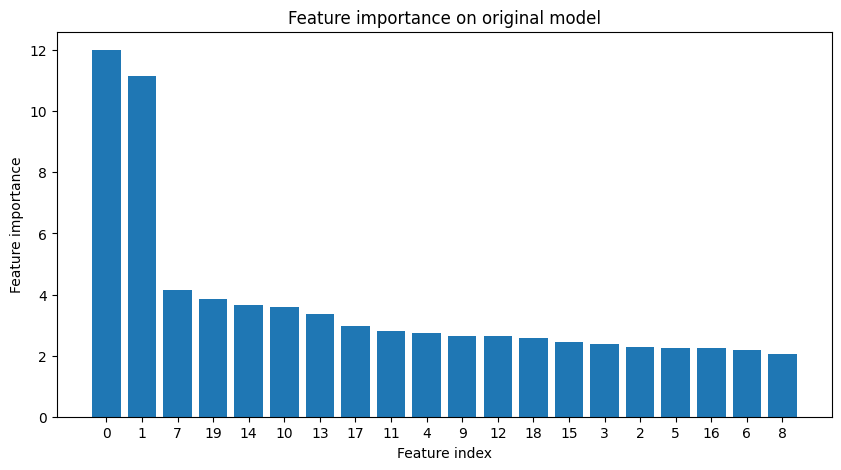

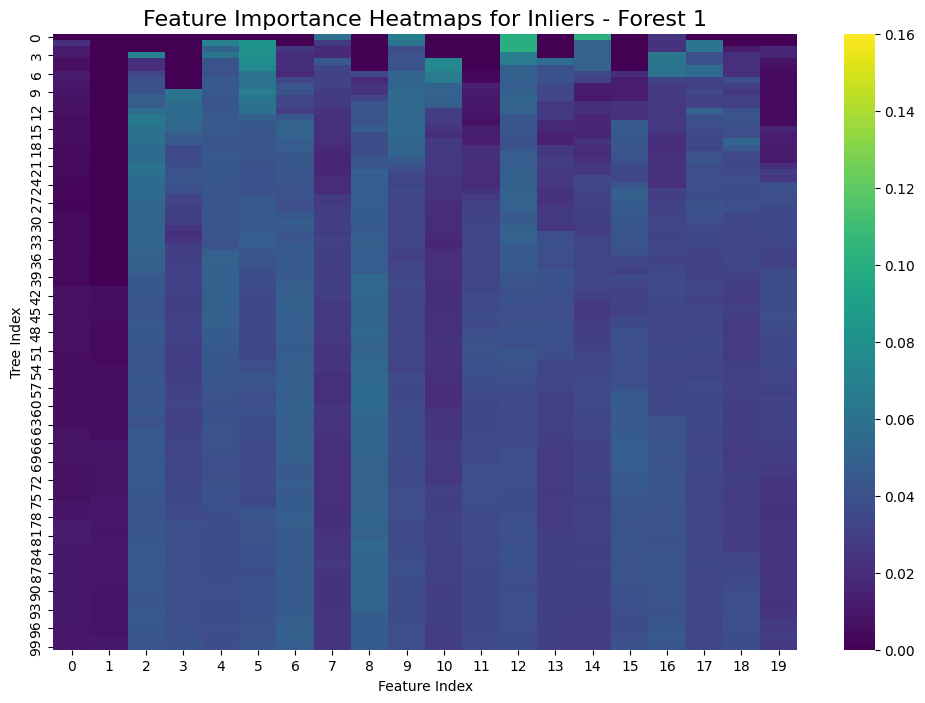

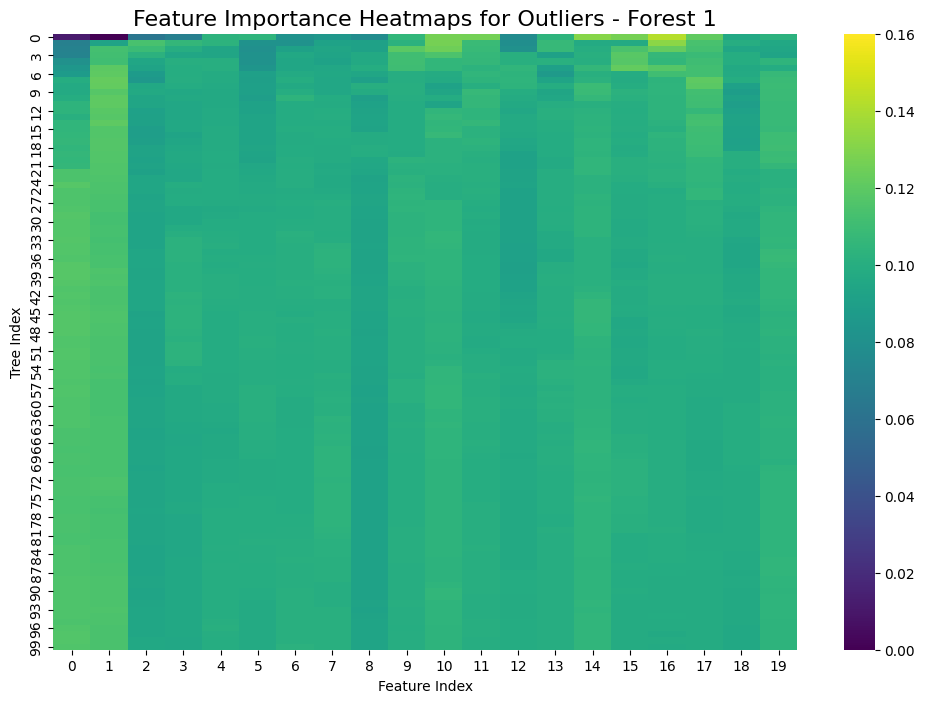

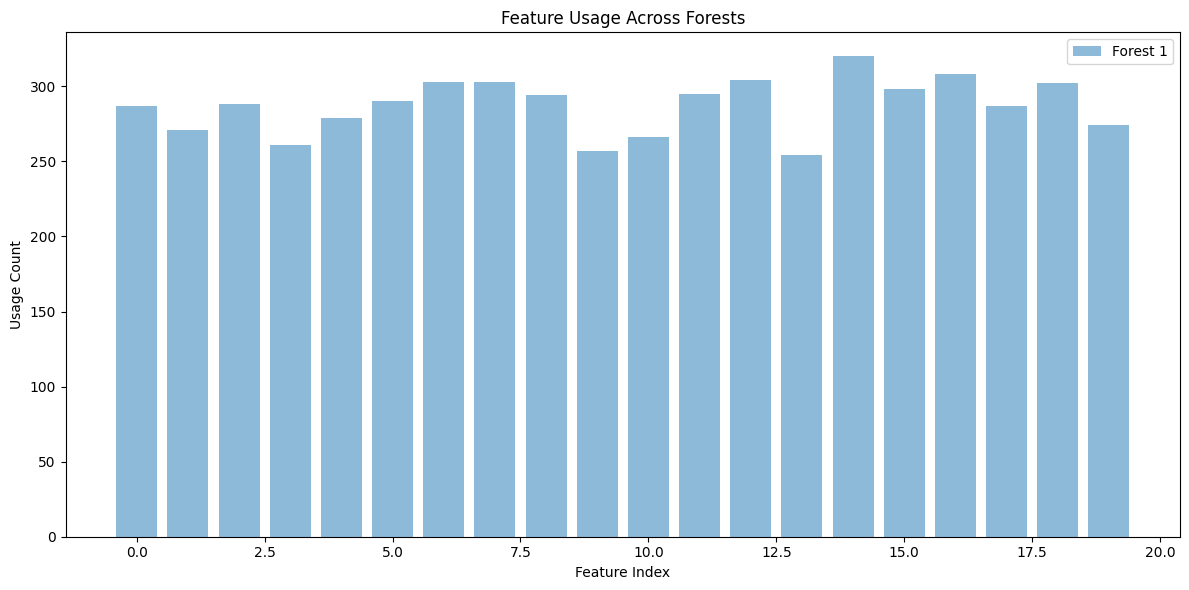

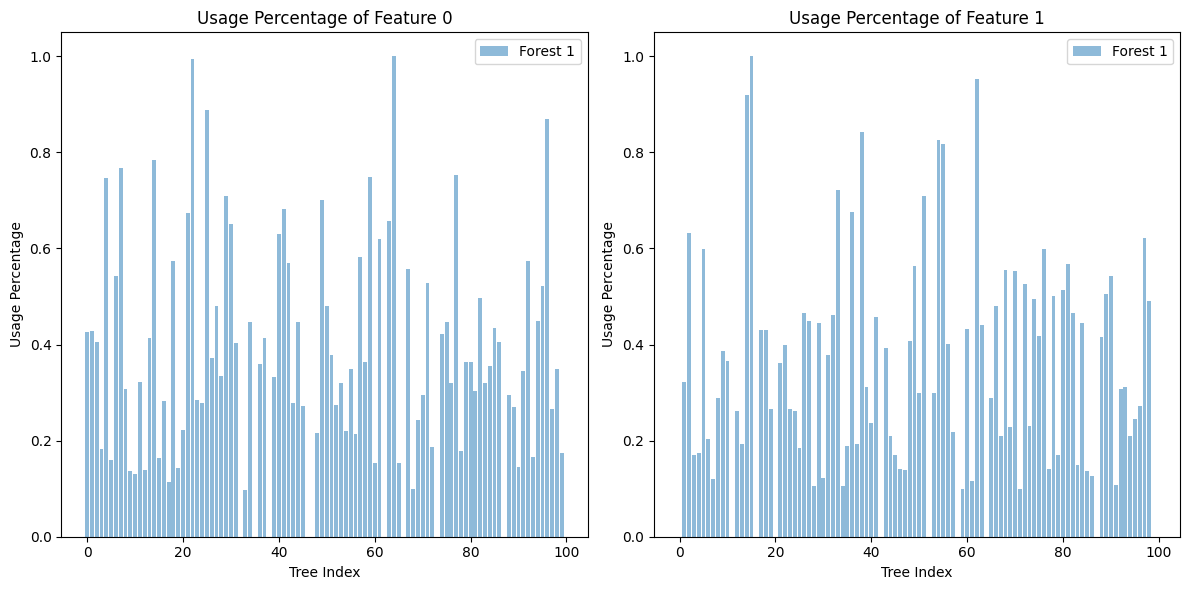

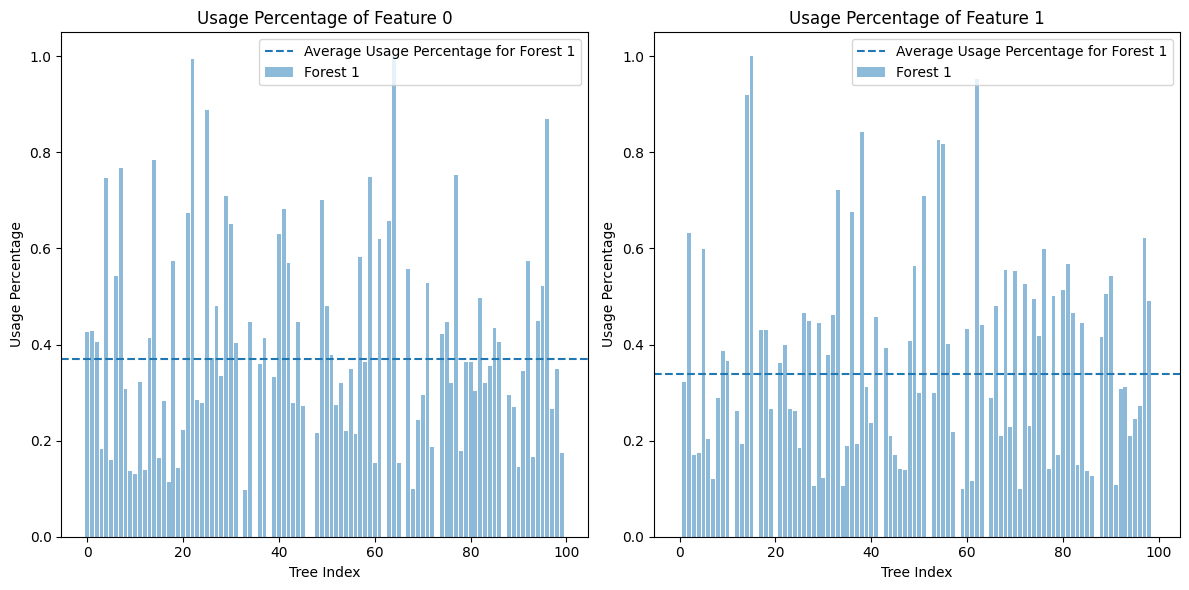

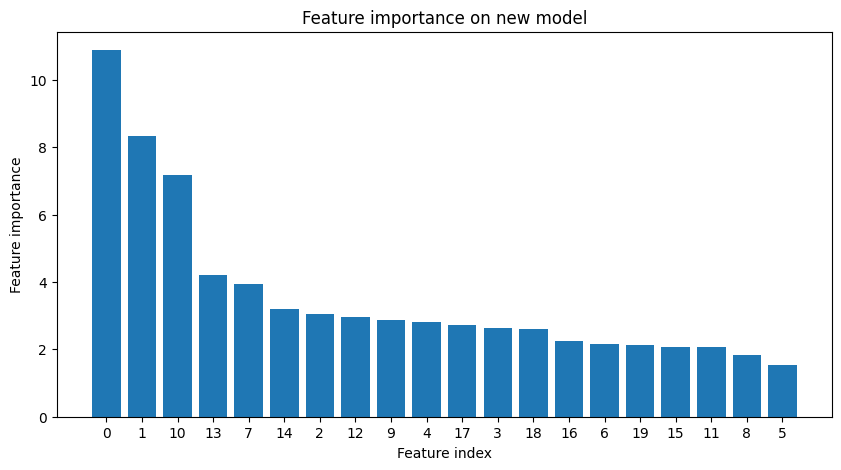

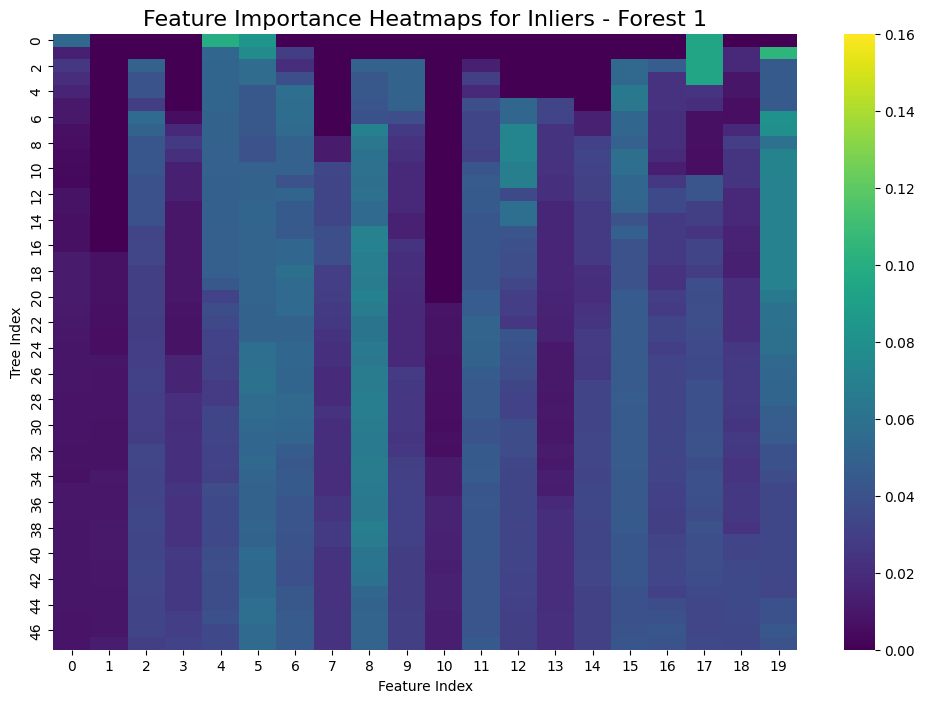

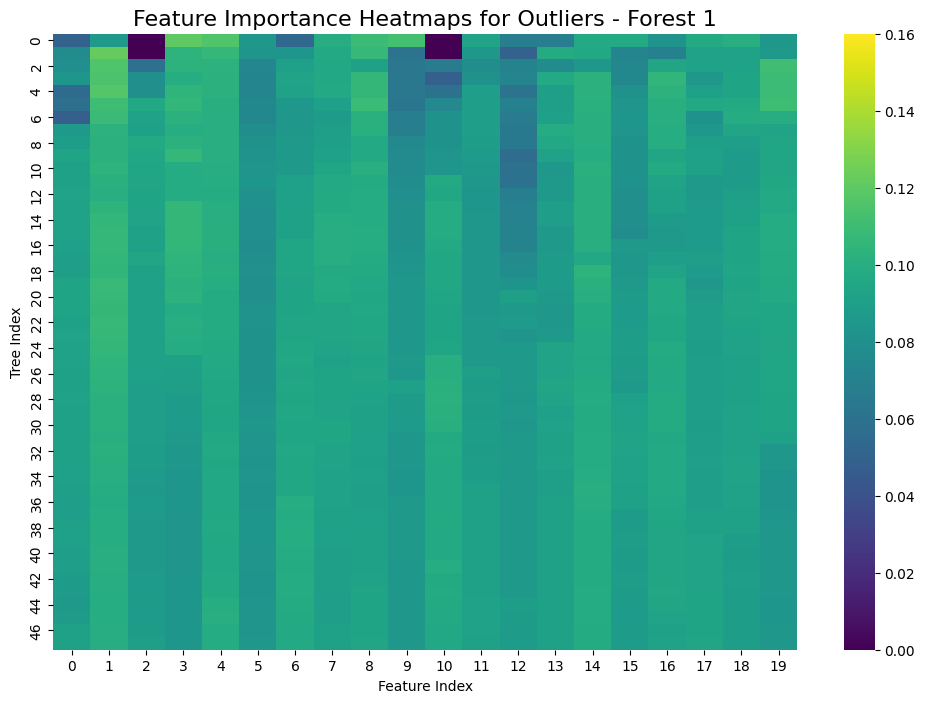

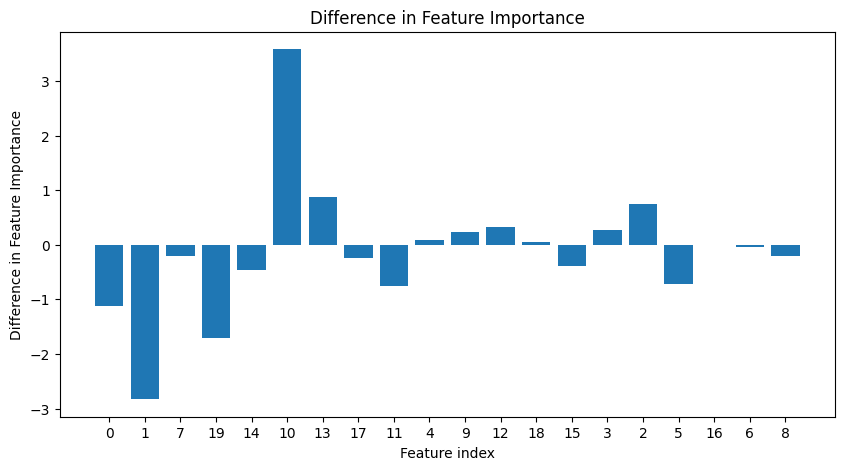

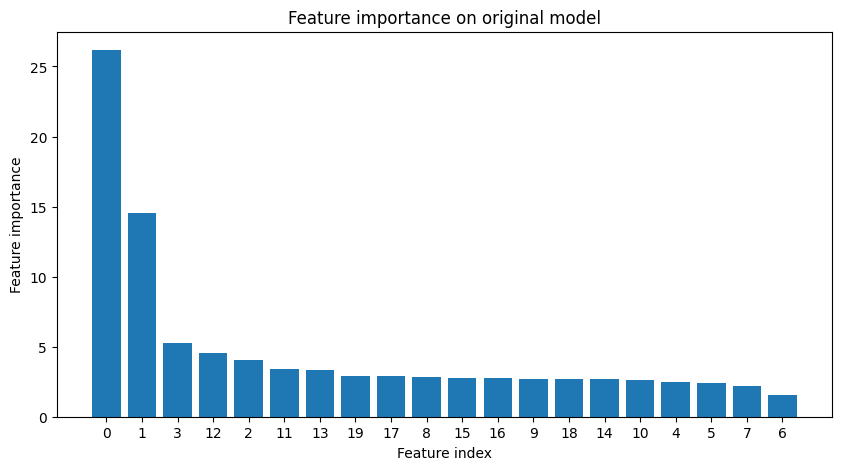

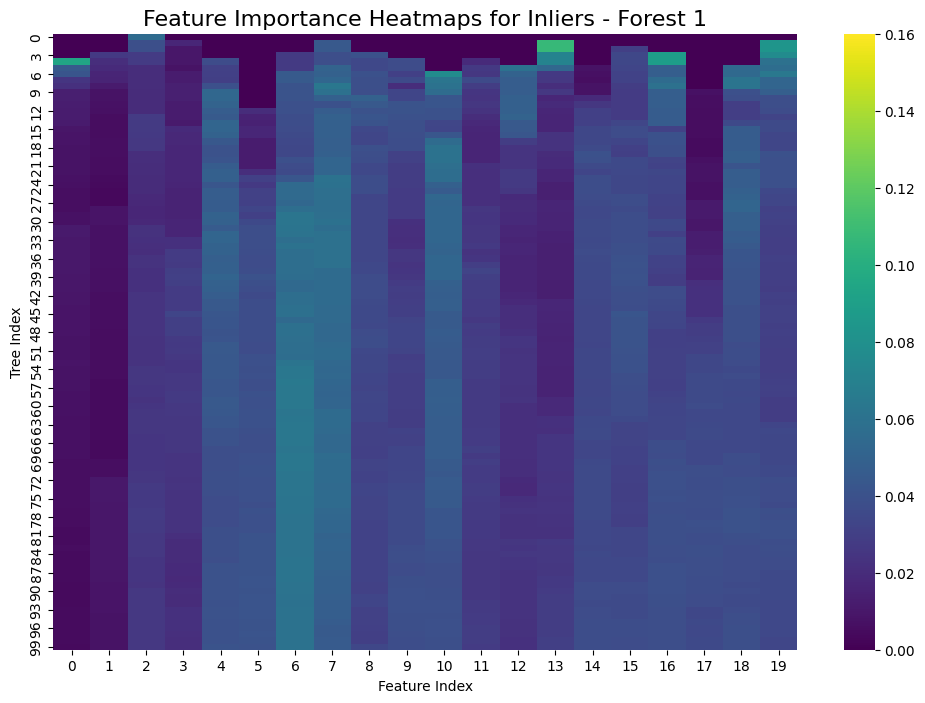

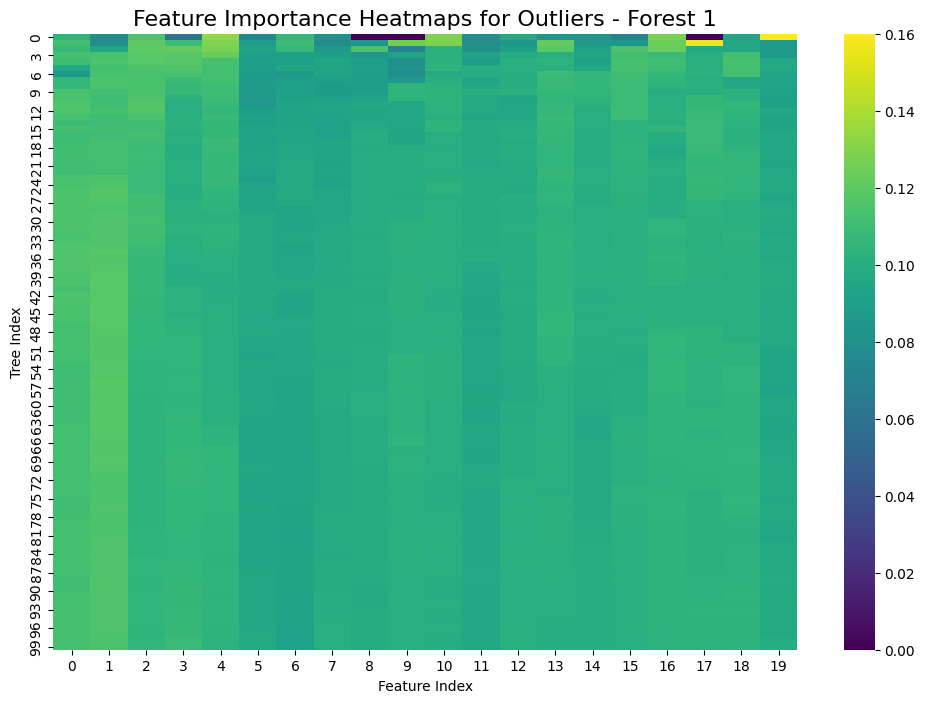

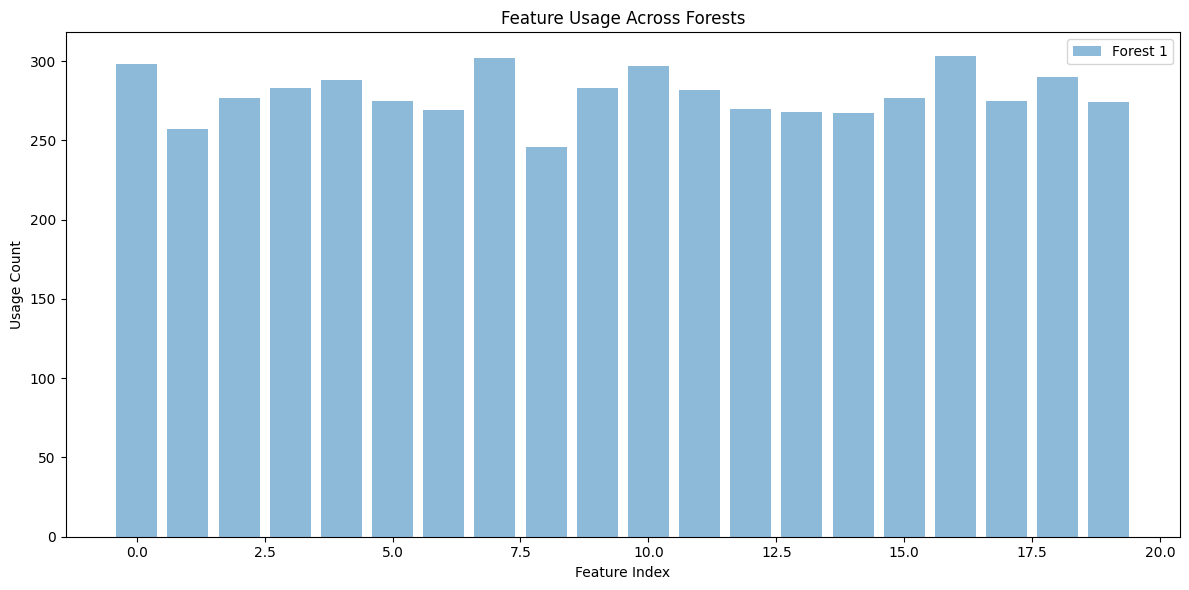

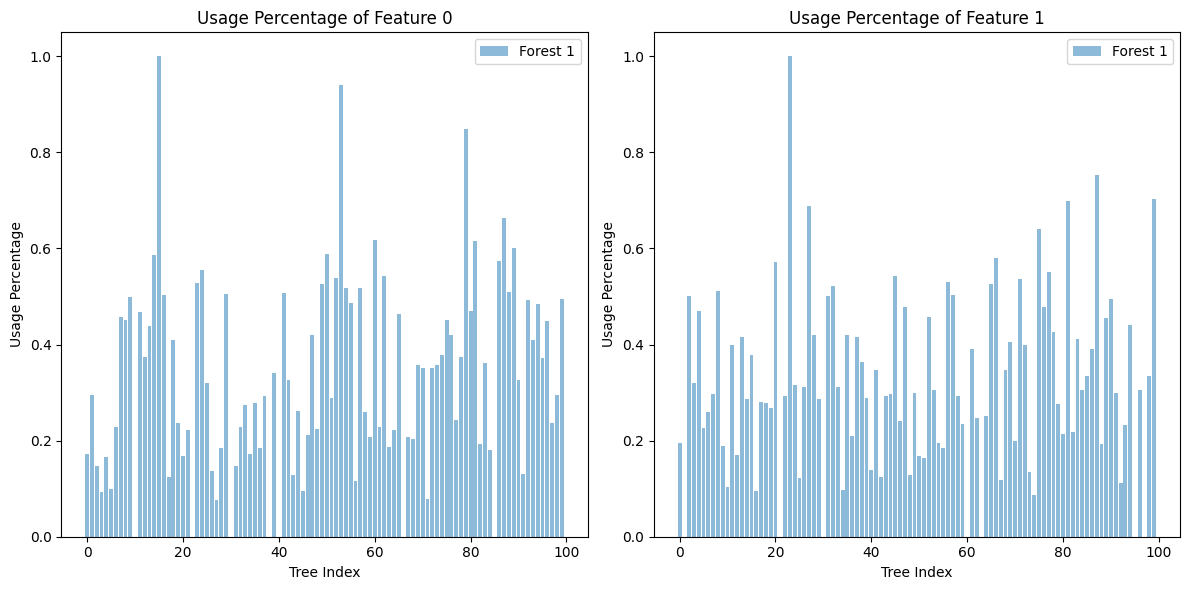

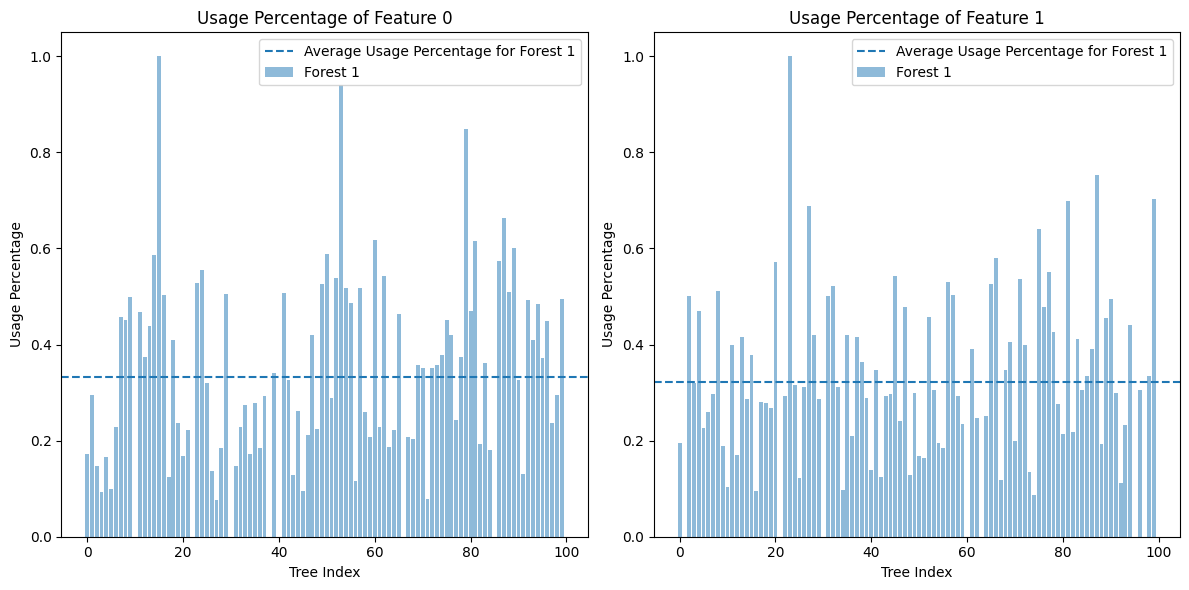

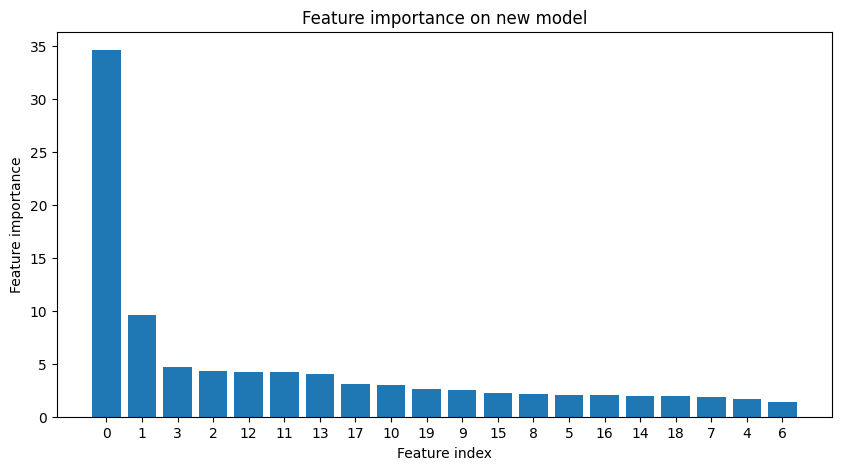

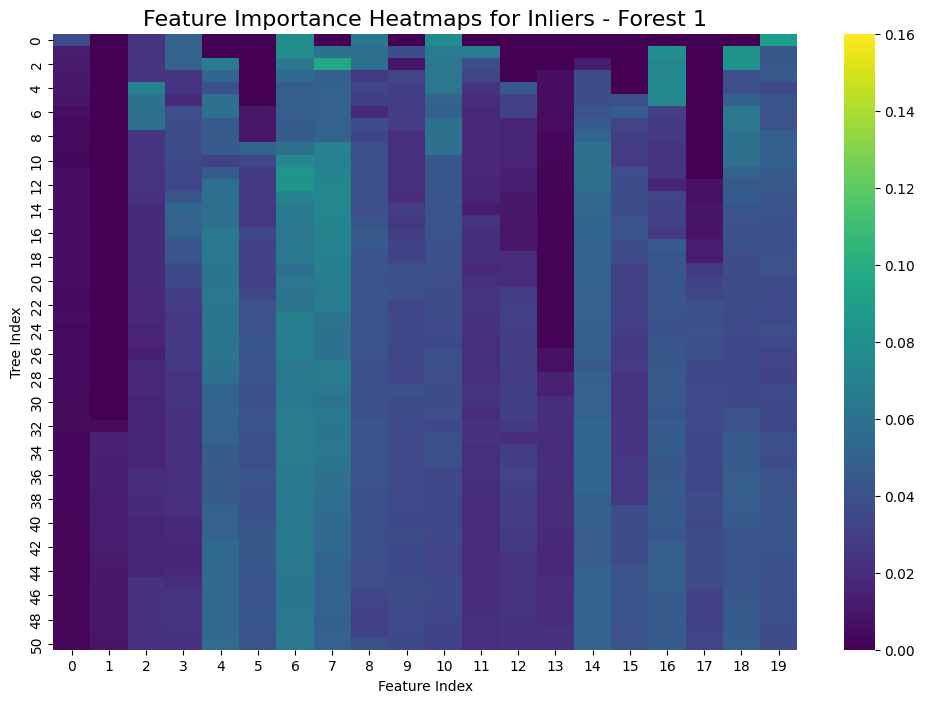

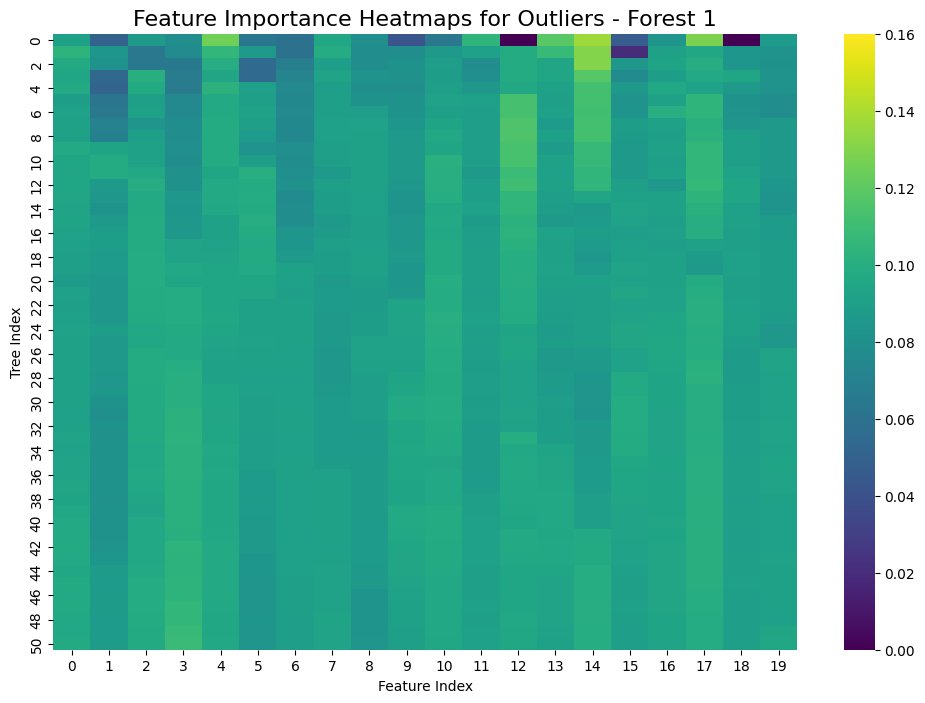

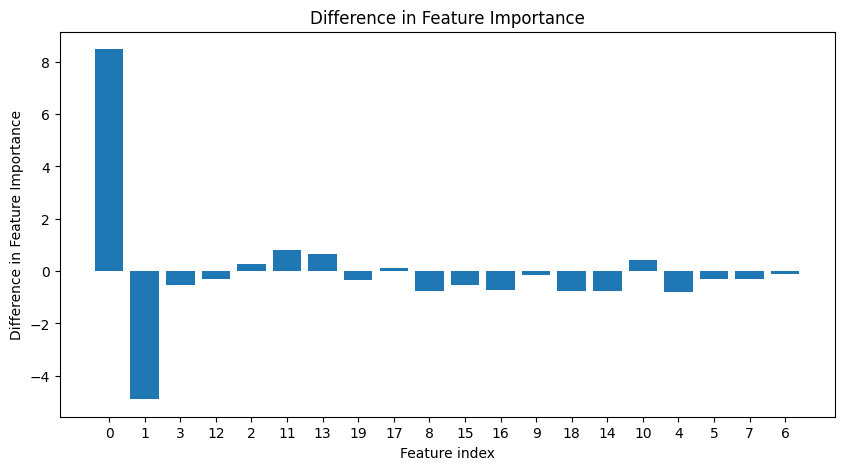

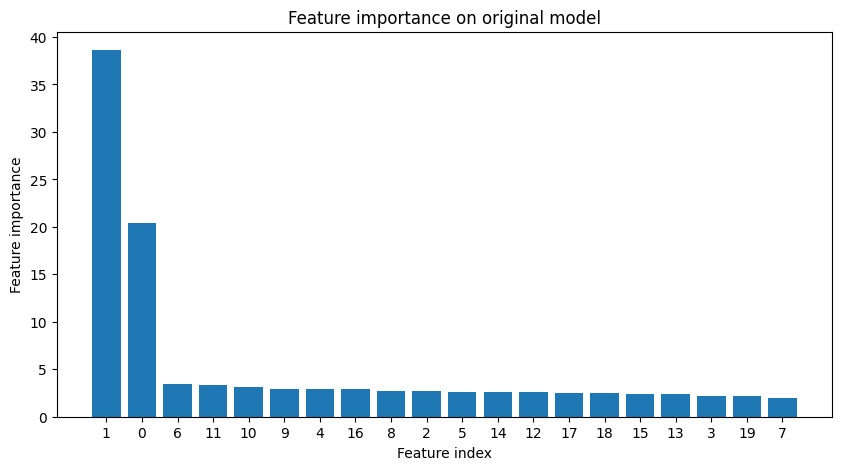

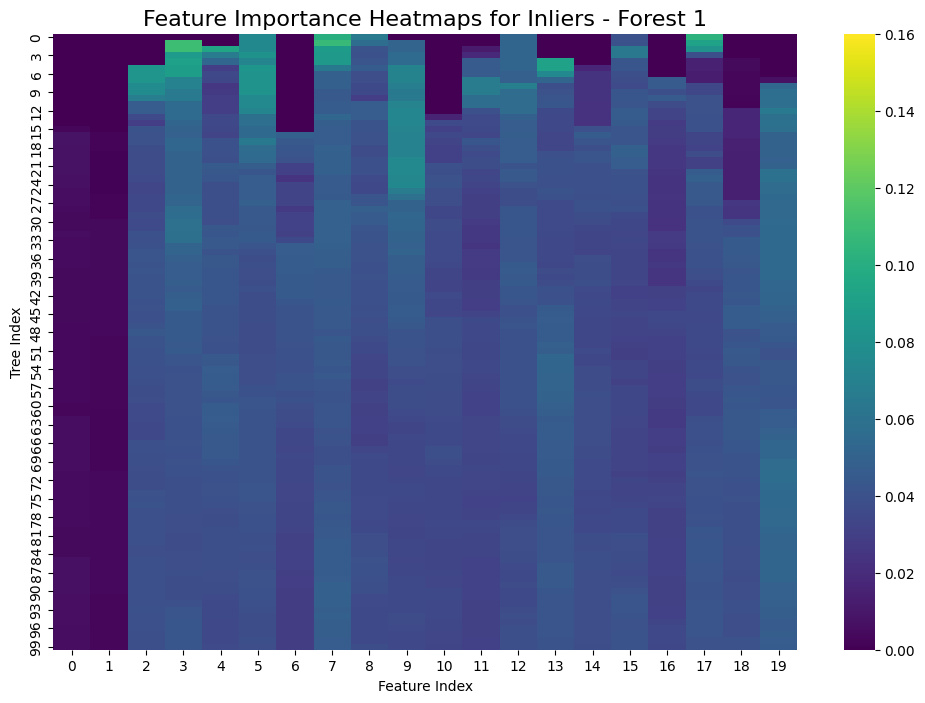

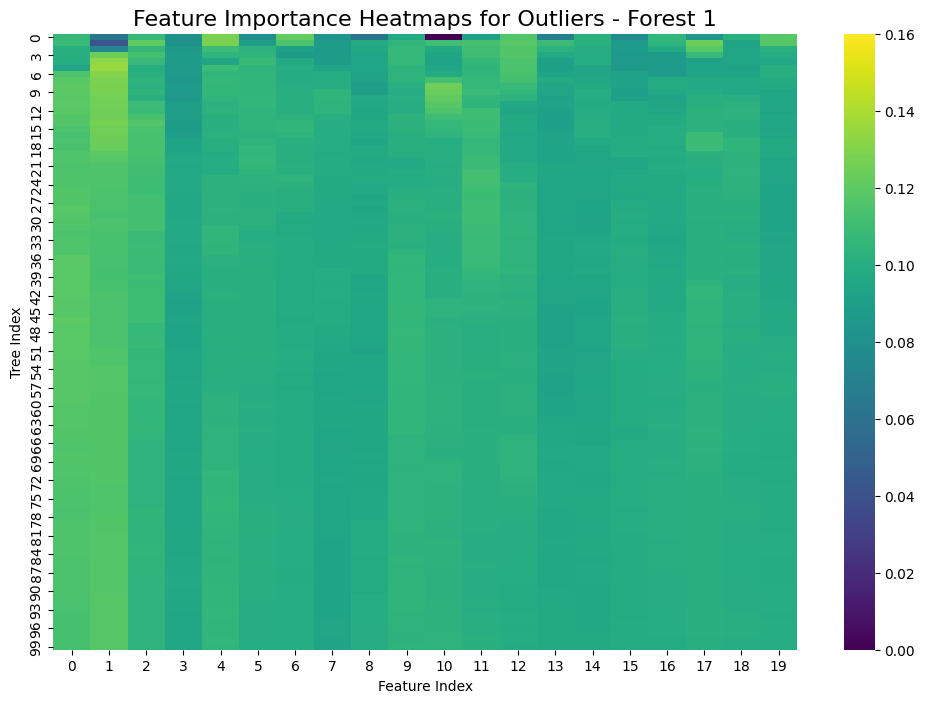

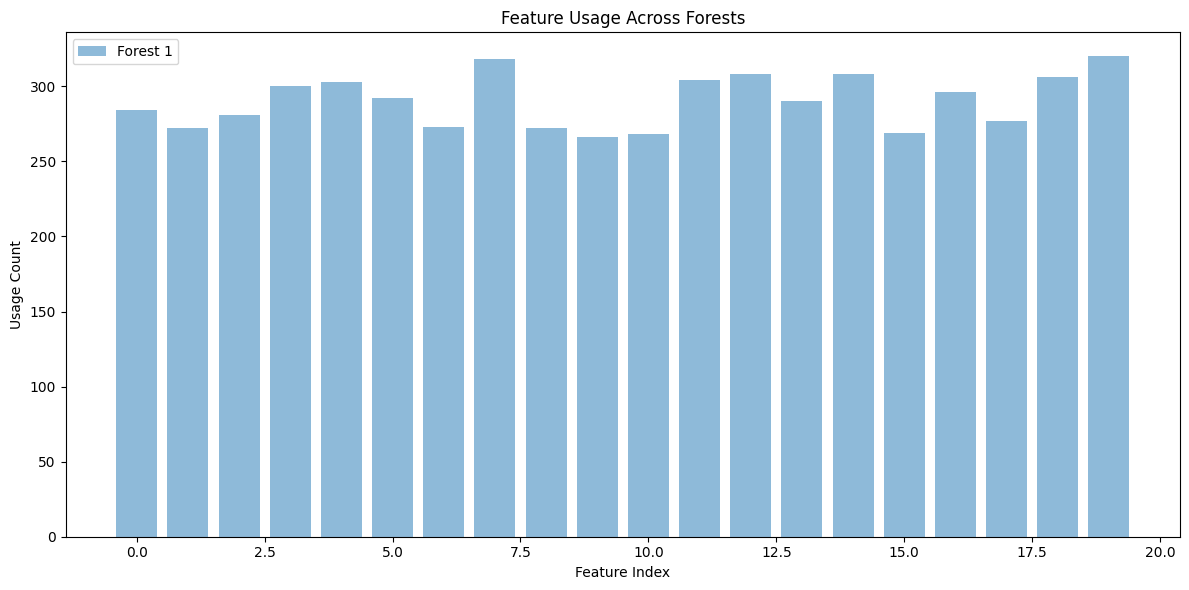

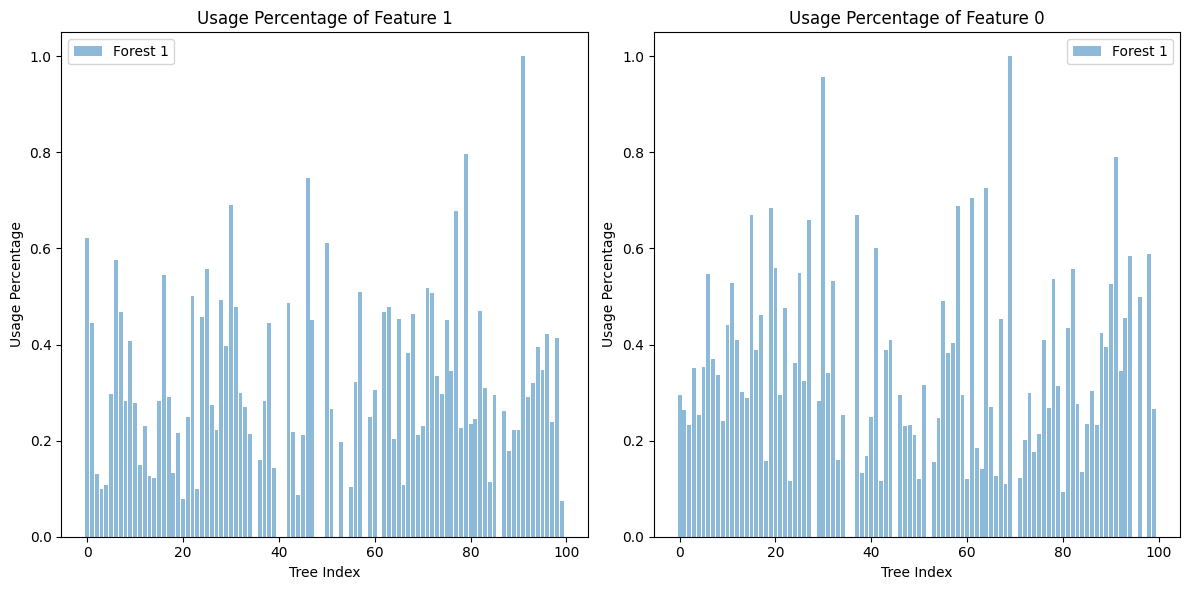

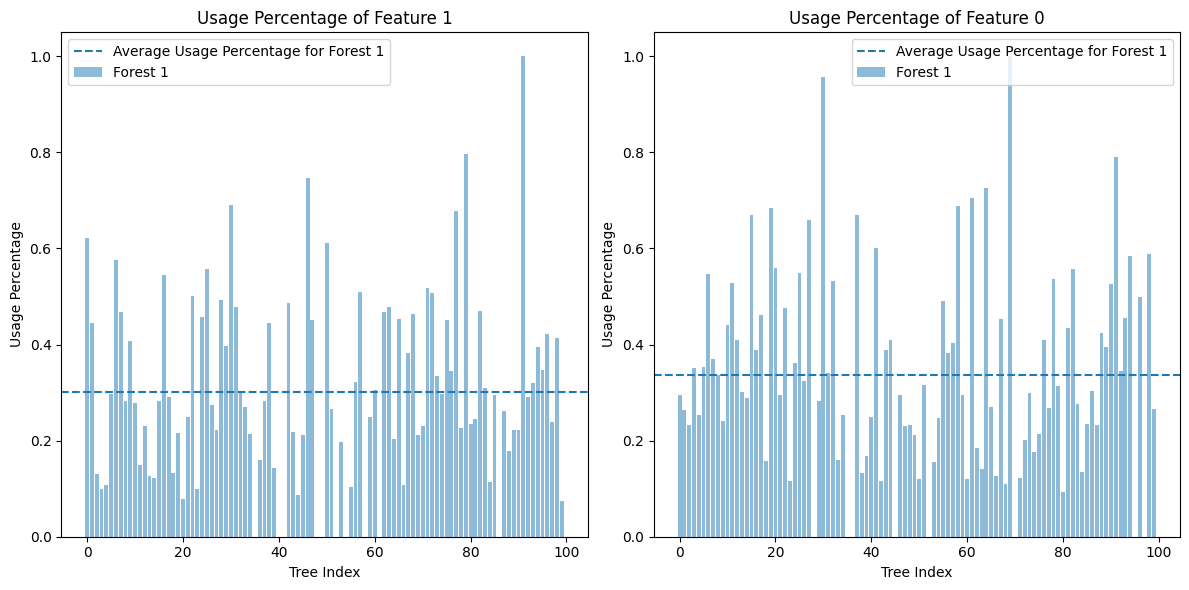

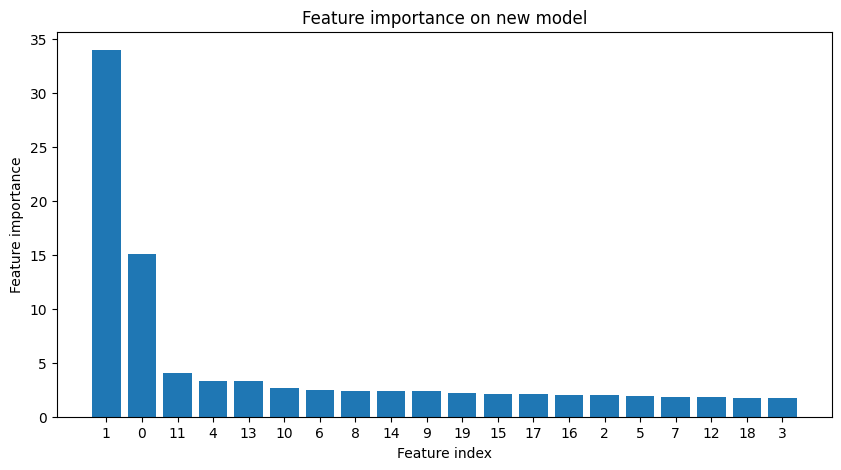

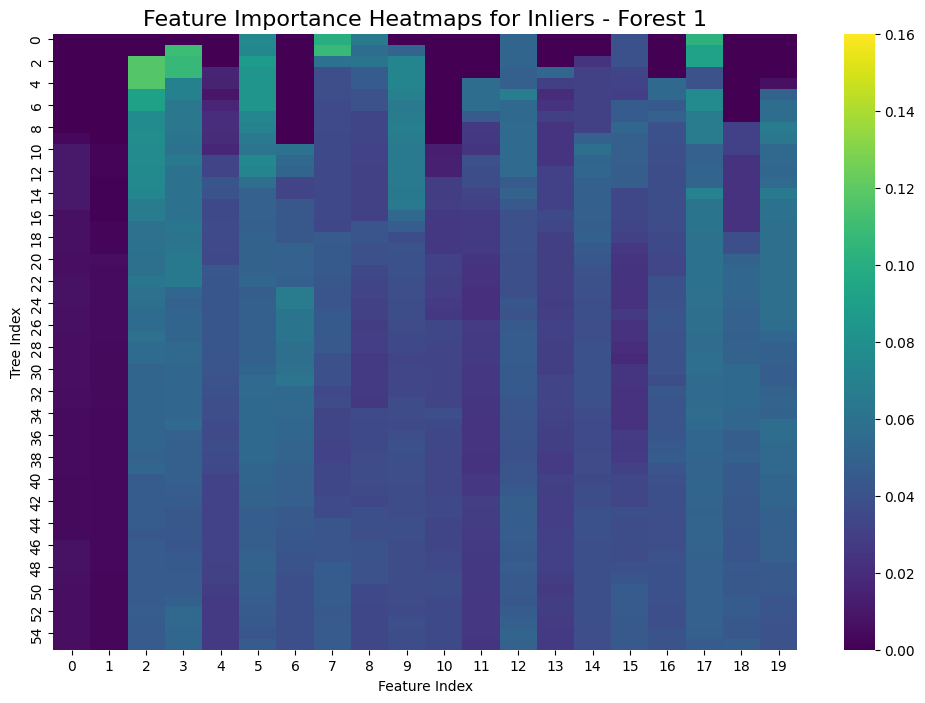

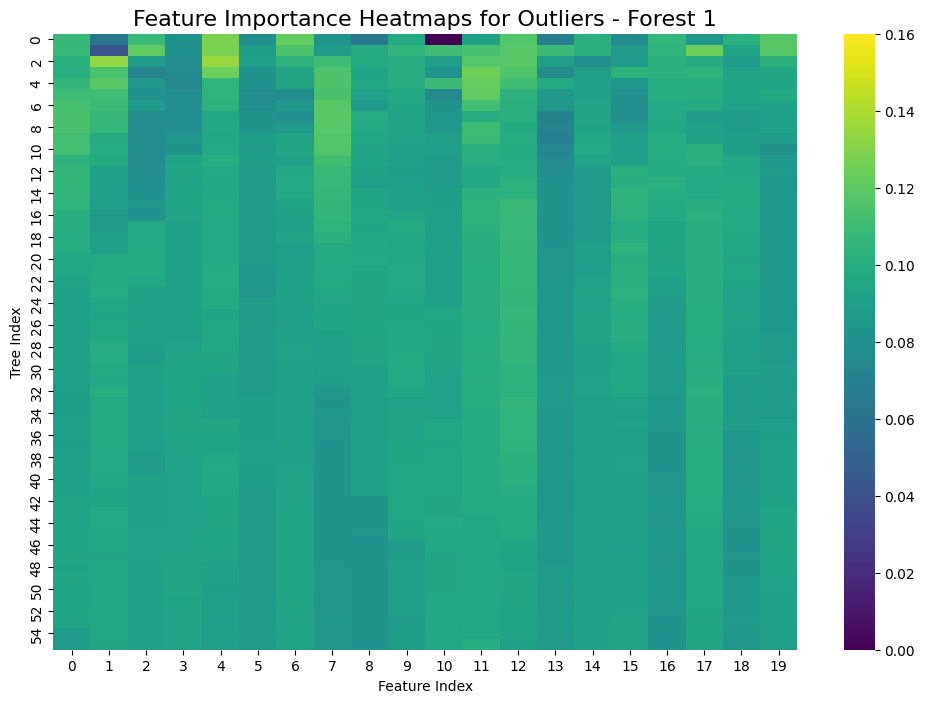

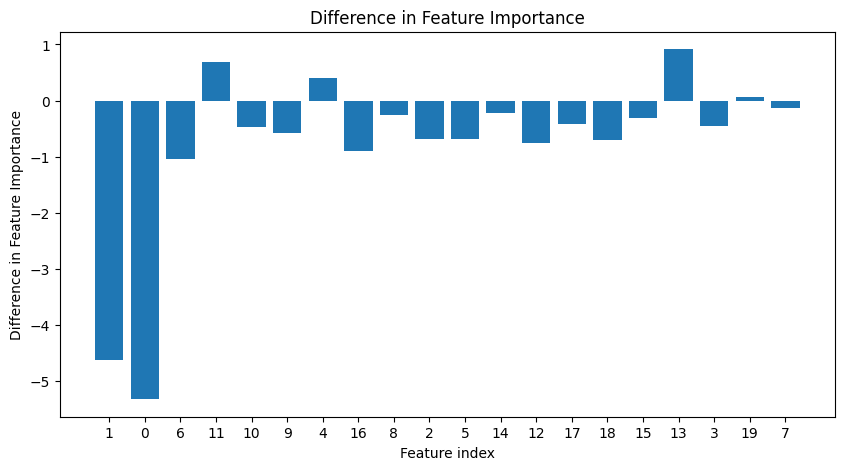

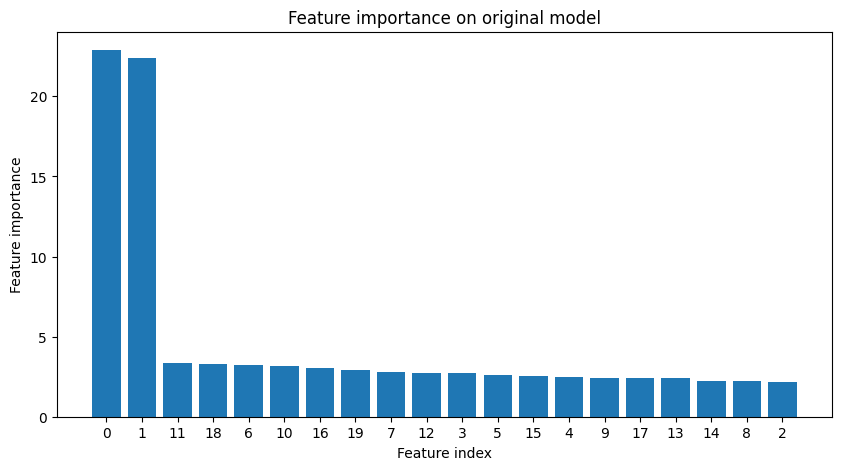

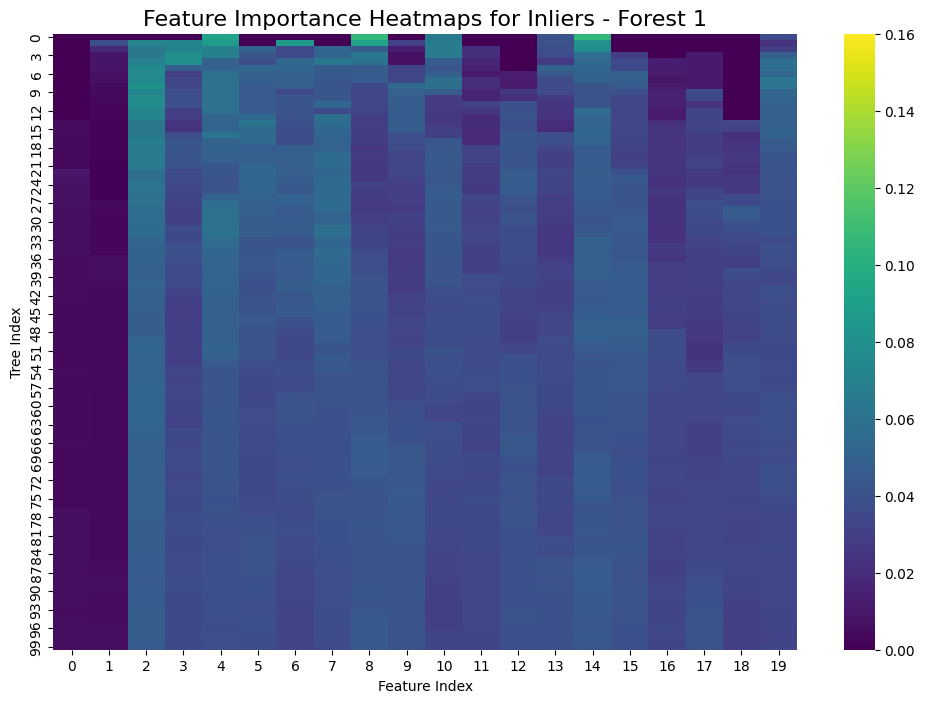

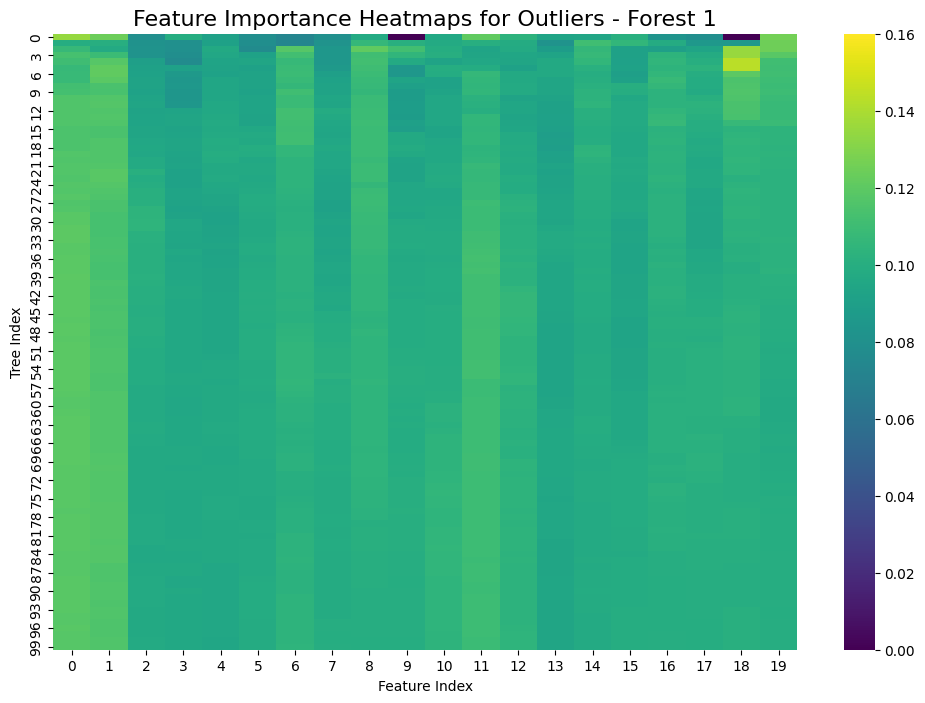

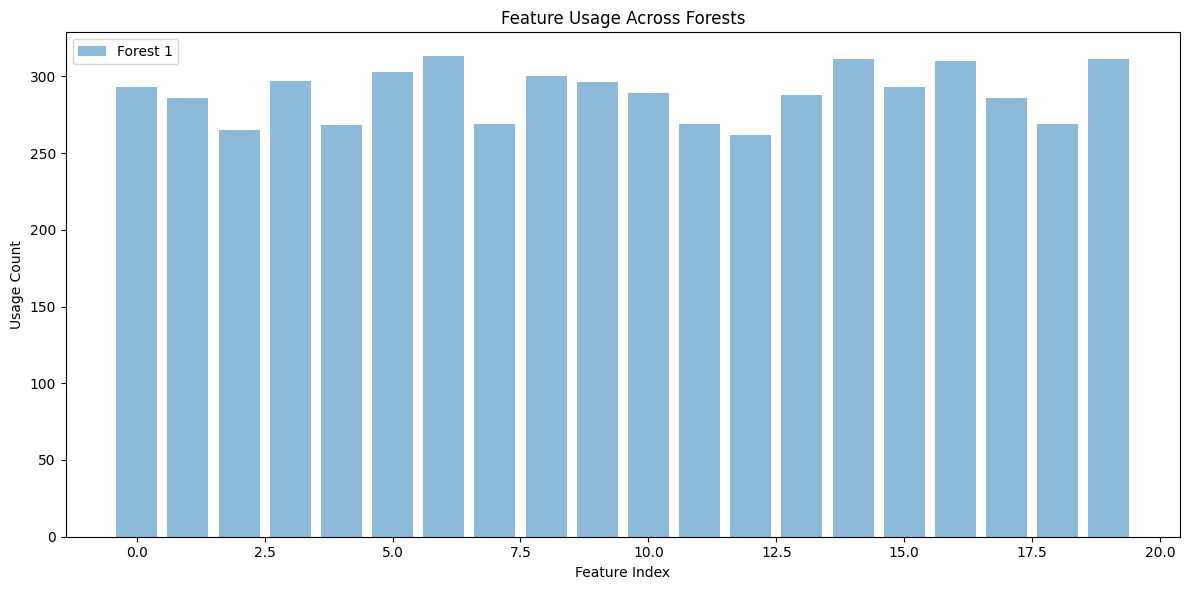

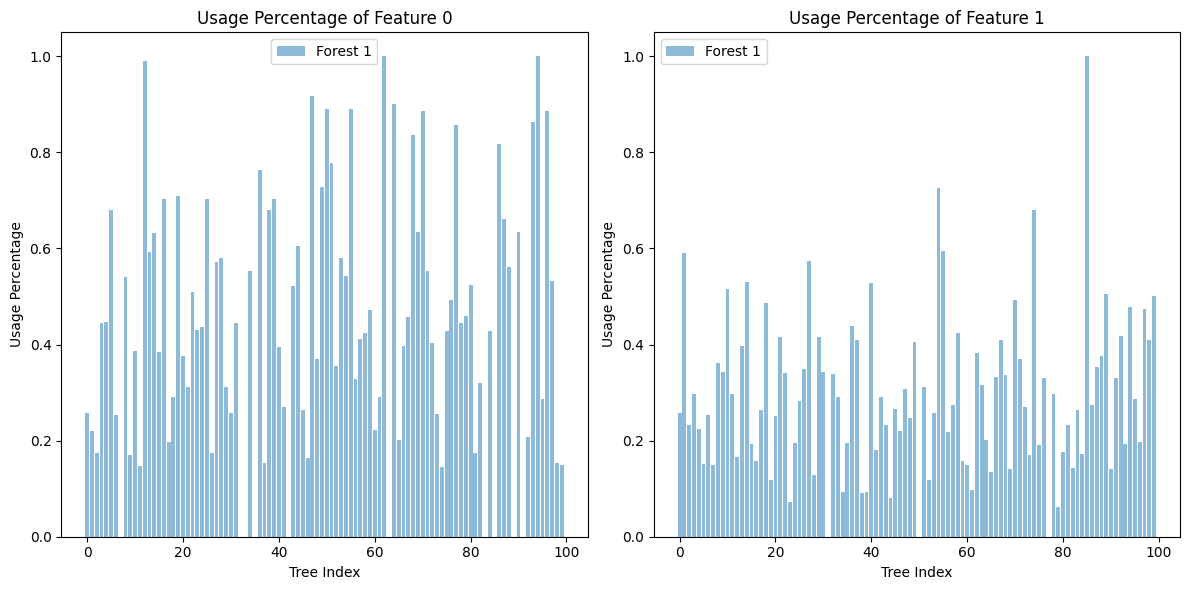

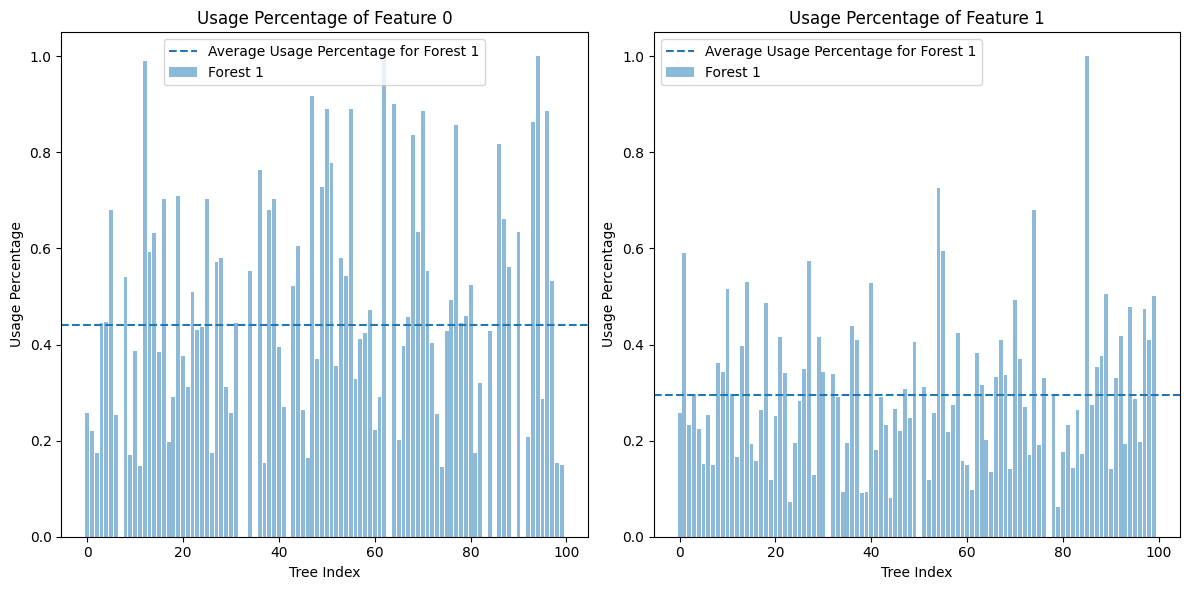

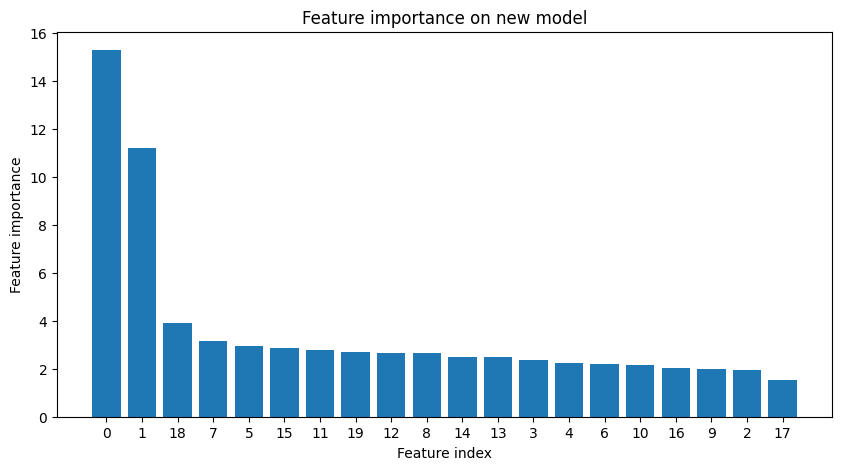

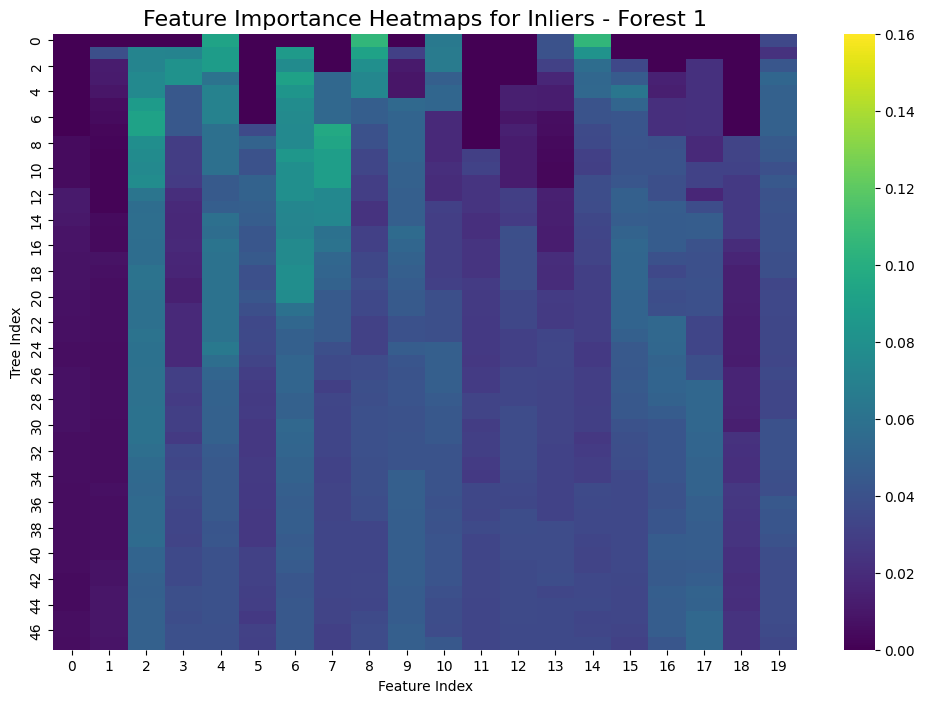

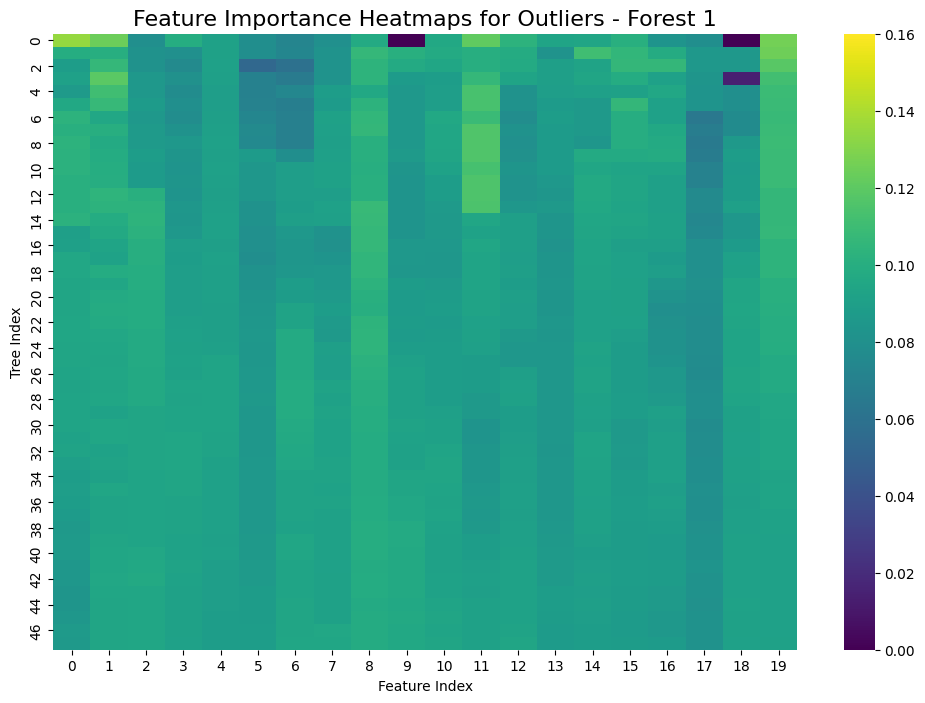

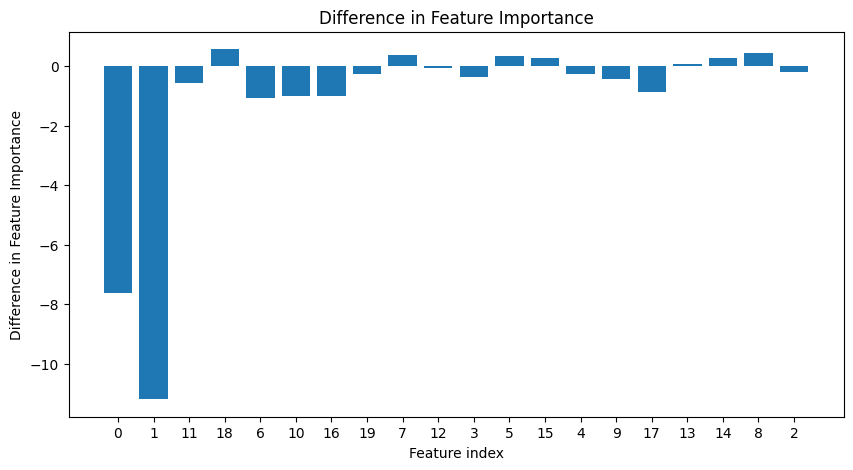

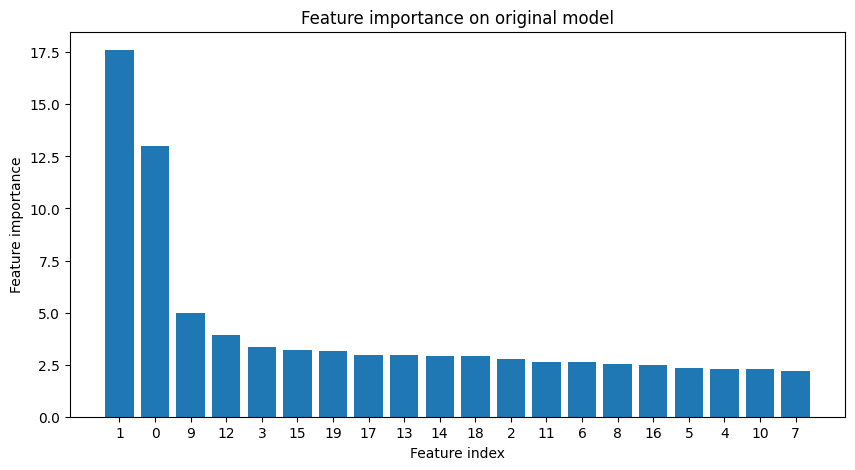

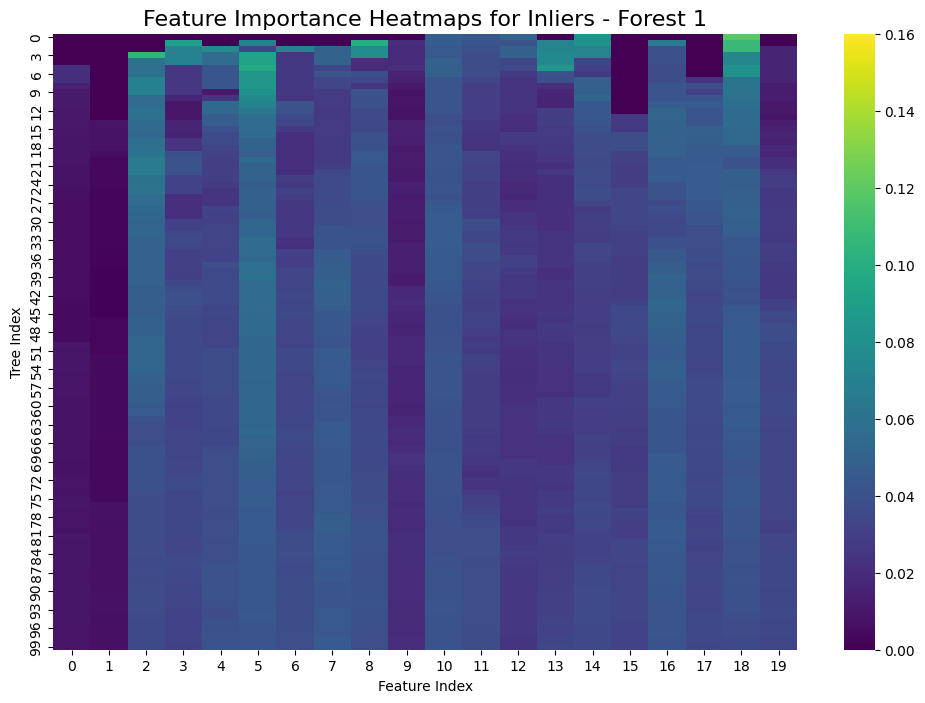

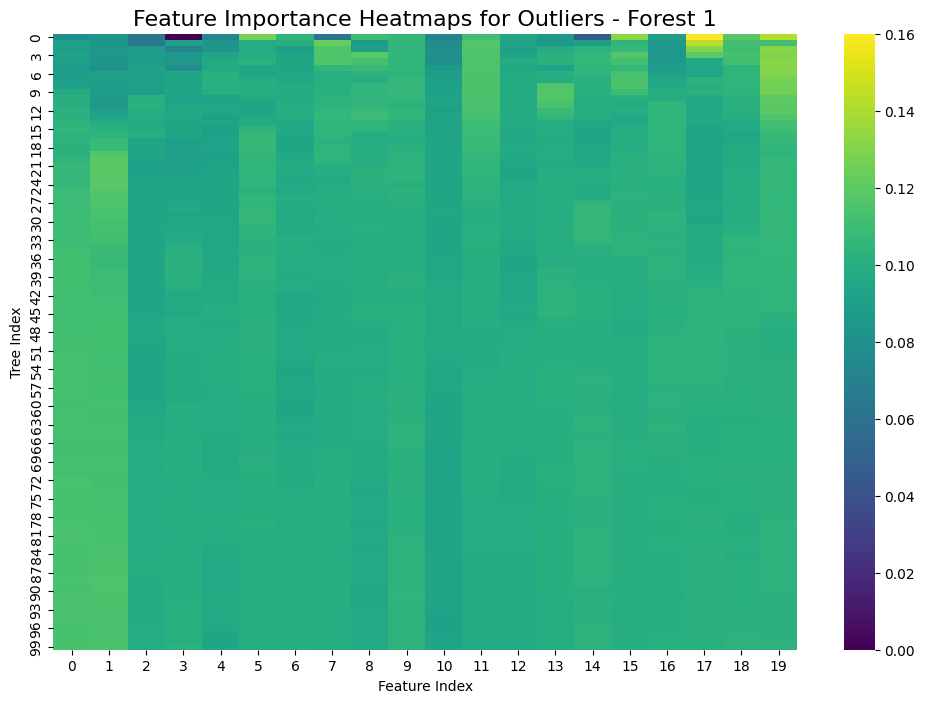

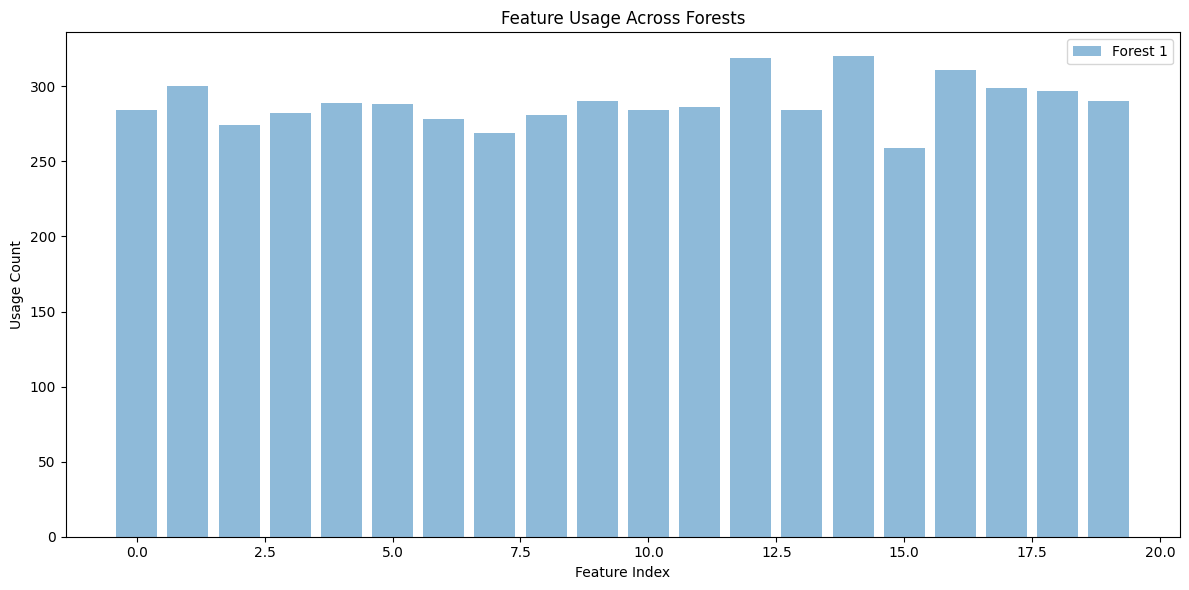

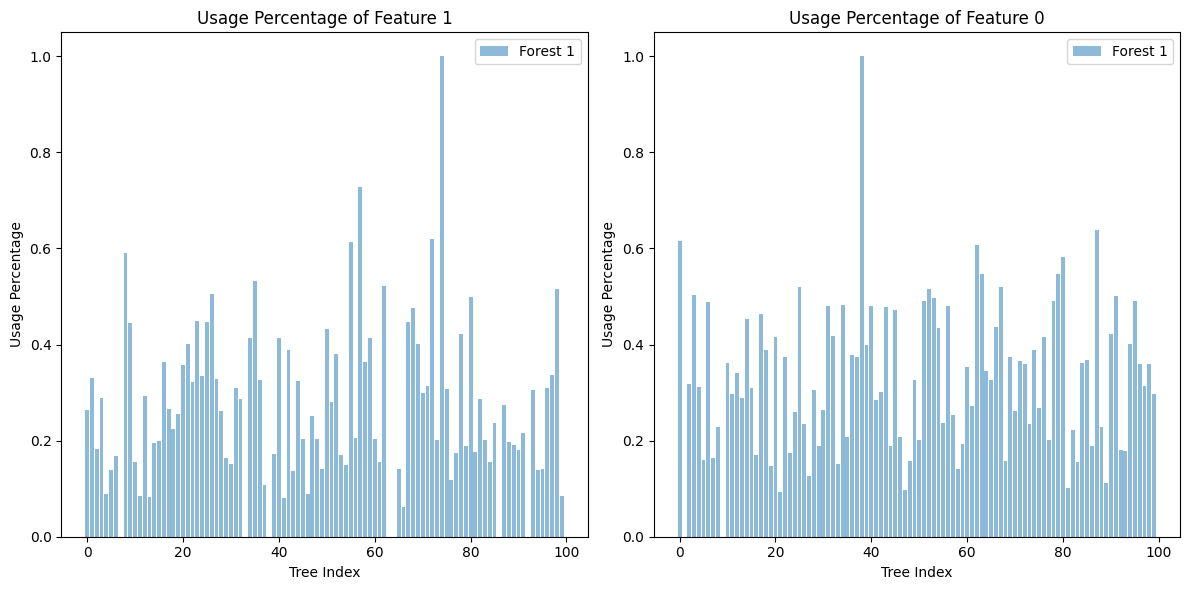

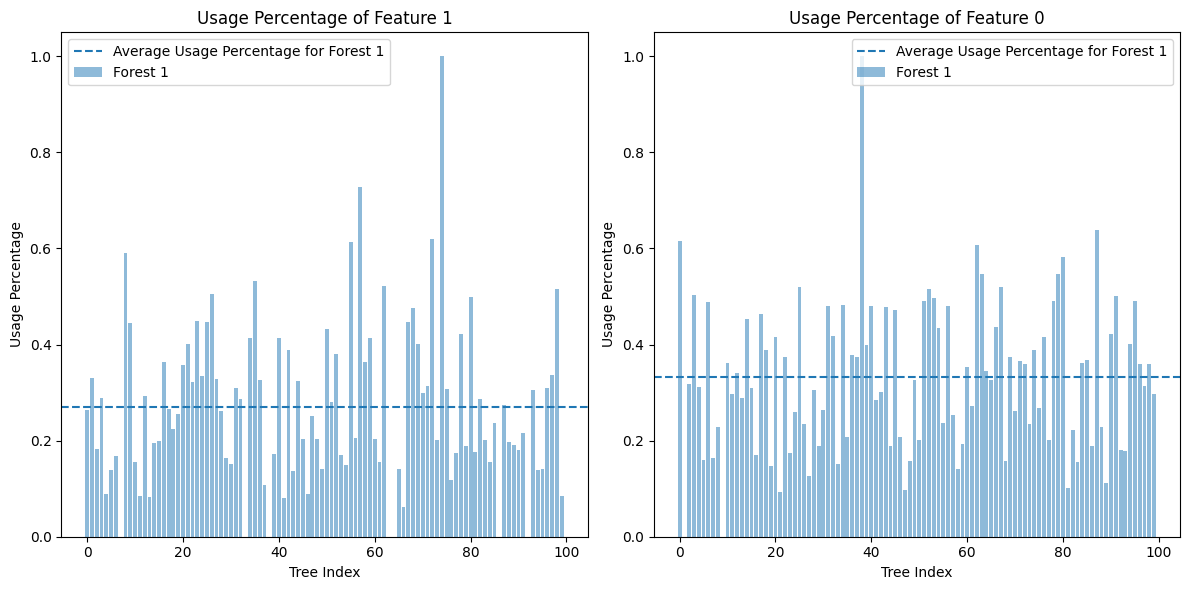

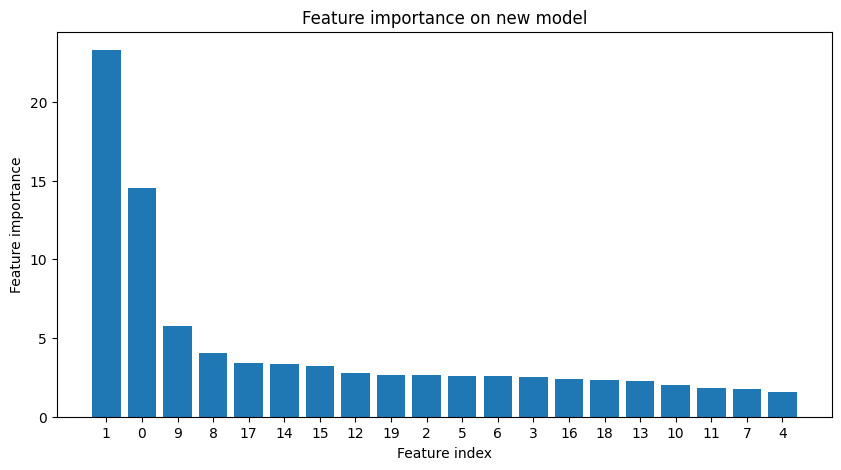

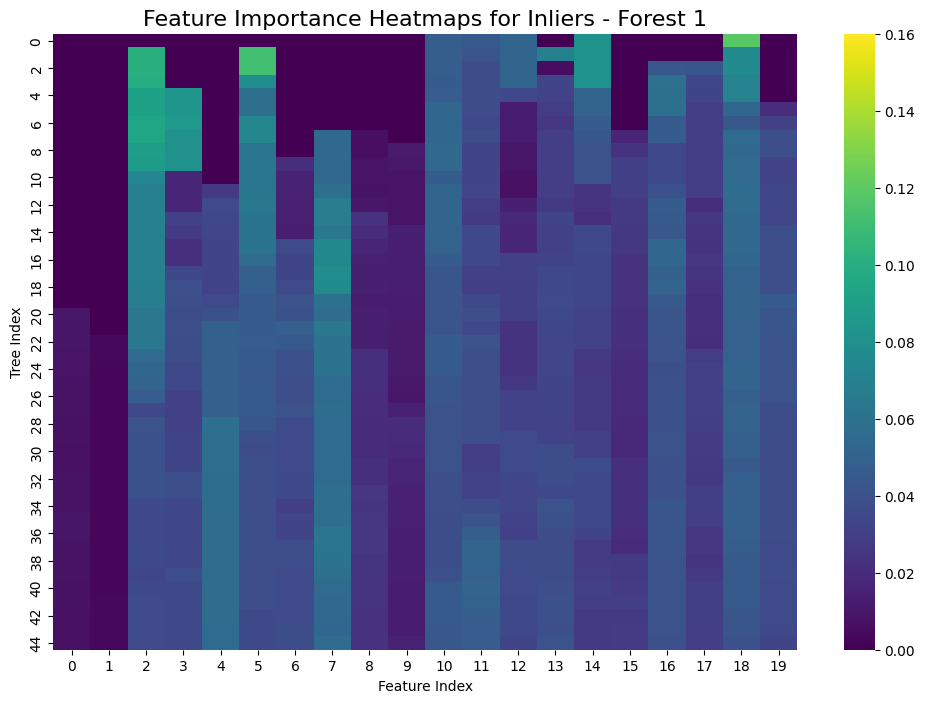

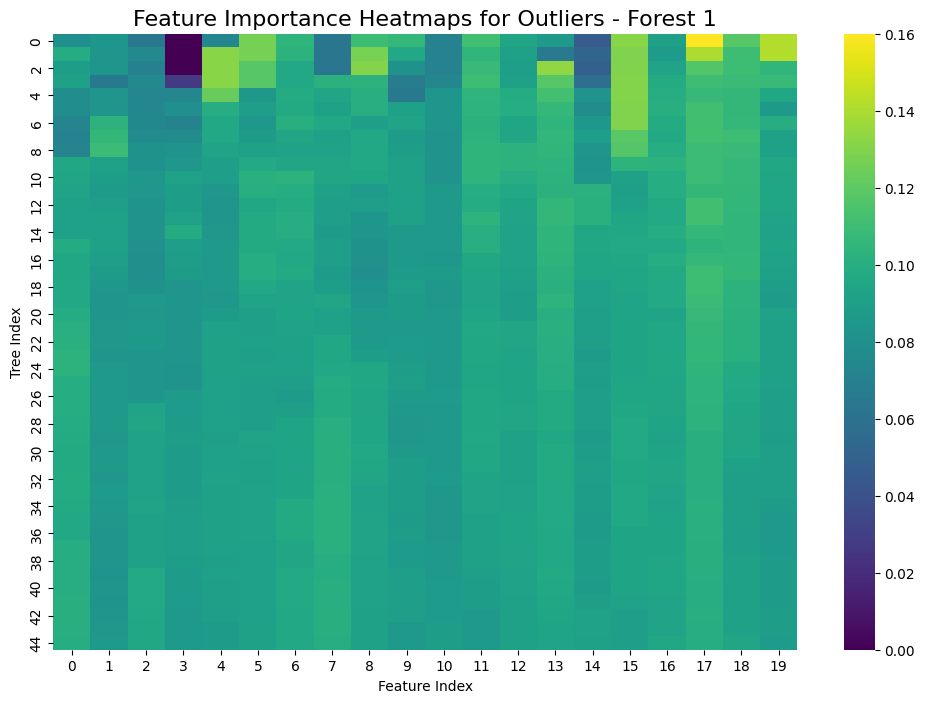

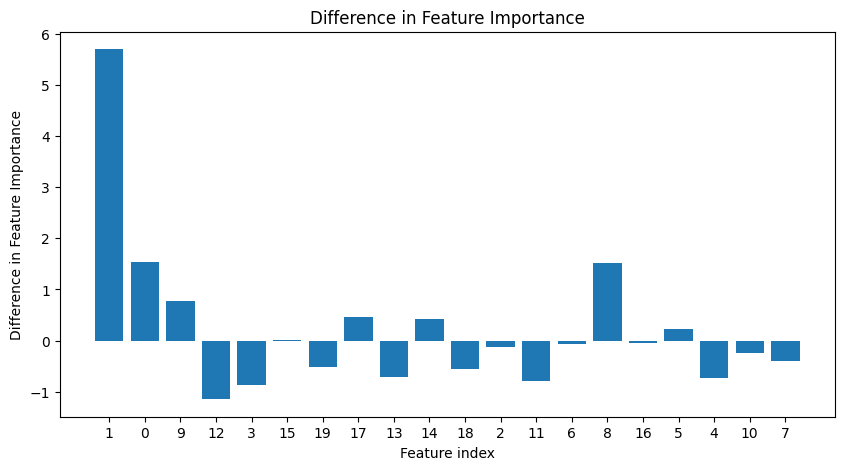

In [ ]:
for seed in [0, 1, 2, 3, 4]:
    print(f"Seed: {seed}\n")

    # Load synthetic dataset
    data, labels, contamination = generate_syn_dataset()

    X_tr, X_te, y_tr, y_te = train_test_split(data, labels, test_size=0.1, random_state=seed)

    # for i, dataset in enumerate(odds_datasets.datasets_names):
    #         X, y = odds_datasets.load(dataset)
    #         contamination = y.mean()
    #         X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, stratify=y)

    X_tr, y_tr = shuffle(X_tr, y_tr, random_state=seed)

    print('Training set size: ', X_tr.shape)
    print('Trainin label size: ', y_tr.shape)

    print('Test set size: ', X_te.shape)
    print('Test label size: ', y_te.shape)

    print('\n')

    num_features = X_tr.shape[1]
    
    # Init wandb to log the results
    run = wandb.init(
        project="diffi_optimization",
        name=f"experiment_forest_{n_forests}_trees_{num_trees}_threshold_{usage_threshold}",
        # job_type="training",
        config={
            "seed": seed,
            "dataset": "synthetic",     # change according to the dataset actually used
            "num_trees": num_trees,
            "max_samples": max_samples,
            "n_forests": n_forests,
            "contamination": contamination,
            "usage_threshold": usage_threshold,
        }
    )

    # TODO: compute also the average precision score
    sorted_idx, avg_f1, fi_means, fi_std, features_per_forest, fi_diffi_all, iforests, fi_diffi_inliers, fi_diffi_outliers = diffi_ranks_per_tree(
        X=X_tr, 
        y=y_tr, 
        n_trees=run.config.num_trees, 
        max_samples=run.config.max_samples, 
        n_iter=run.config.n_forests, 
        seed=seed,
        contamination=run.config.contamination) 
    
    print('Average F1 score: {:.4f}'.format(avg_f1))

    print('\n')
    
    num_forests = len(features_per_forest)
    num_trees = len(features_per_forest[0])
    
    log_model_config(run.config.contamination)

    log_feature_importance(sorted_idx, fi_means, fi_std, og_model=True)

    # Getting the most important features
    most_important_features = sorted_idx[:2]
    print('Most important features:', most_important_features)   

    print('\n')

    log_feature_importance_heatmap(fi_diffi_inliers, for_inliers=True)
    log_feature_importance_heatmap(fi_diffi_outliers, for_inliers=False)

    usage_per_forest, usage_per_tree = feature_usage(features_per_forest=features_per_forest, num_features=num_features)

    most_important_features_usage_percentage = most_important_feature_usage(most_important_features=most_important_features,
                                                                            usage_per_tree=usage_per_tree, 
                                                                            features_per_forest=features_per_forest)

    average_usage(most_important_features_usage_percentage, most_important_features=most_important_features)

    print('\n')

    removing_trees(most_important_features_usage_percentage, most_important_features=most_important_features, iforests=iforests)

    print('\n')

    #TODO: compute also the average precision score
    new_sorted_idx, new_avg_f1, new_fi_means, new_fi_std, new_features_per_forest, new_fi_diffi_all, new_fi_diffi_inliers, new_fi_diffi_outliers = diffi_ranks_evaluation_only(
        X=X_tr, y=y_tr, iforest=iforests) 

    print('New average F1 score: {:.4f}'.format(new_avg_f1))

    print('\n')

    #TODO: check new_fi_diffi_inliers, new_fi_diffi_outliers

    log_feature_importance(new_sorted_idx, new_fi_means, new_fi_std, og_model=False)

    log_feature_importance_heatmap(new_fi_diffi_inliers, for_inliers=True)
    log_feature_importance_heatmap(new_fi_diffi_outliers, for_inliers=False)

    # Log number of estimators in each forest of the new model
    data = [[f"Forest {i+1}", len(iforests[i].estimators_)] for i in range(len(iforests))]
    columns = ["Forest", "Number of Estimators"]

    num_estimators_table = wandb.Table(data=data, columns=columns)

    run.log({"Number of Estimators Table in the new model": num_estimators_table})

    # Log the F1 scores
    data = [[num_forests, avg_f1, new_avg_f1]]
    columns = ["Forest", "Original F1 Score", "New F1 Score"]

    avg_f1_scores_table = wandb.Table(data=data, columns=columns)

    run.log({
        "F1 Scores Table": avg_f1_scores_table
    })

    # Log the feature importance difference
    compute_difference(fi_means, new_fi_means, sorted_idx)

    print("---------------------------------------------------------------------------")

In [18]:
run.finish()